# Predicting Subcellular Localisation 

This notebook contains the code to build a classifier for protein subcellular location prediction. 

The notebook contains the following sections:
- Data Loading and Exploration 
- Feature Engineering
- Processing 
- Feature Selection
- Model Training
- Model Evaluation on Test Data 

The accompanying report is included in the PDF file of this repository, this includes a code overview in the Appendix. 

In [ ]:
# imports

import numpy as np
import pandas as pd 
from numpy import genfromtxt
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sn
from scipy.stats import randint

from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import BorderlineSMOTE 
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE 
from imblearn.combine import SMOTEENN, SMOTETomek 

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import GridSearchCV

## Data Loading and Exploration

In this section, the data is loaded and explored. Some basic data processing is also done. 

The dataset is composed of FASTA files, which contain the amino acid sequence for a protein, and the location of that protein. 

More information on FASTA file formats can be found here: https://www.ncbi.nlm.nih.gov/genbank/fastaformat/

In [139]:
# load the data
with open('data/cyto.fasta') as fasta_file:
    cyto_sequences = []
    cyto_lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  
        cyto_sequences.append(seq_record.seq)
        cyto_lengths.append(len(seq_record.seq))

with open('data/mito.fasta') as fasta_file: 
    mito_sequences = []
    mito_lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  
        mito_sequences.append(seq_record.seq)
        mito_lengths.append(len(seq_record.seq))
        
with open('data/nucleus.fasta') as fasta_file:
    nuc_sequences = []
    nuc_lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  
        nuc_sequences.append(seq_record.seq)
        nuc_lengths.append(len(seq_record.seq))

with open('data/other.fasta') as fasta_file:
    other_sequences = []
    other_lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  
        other_sequences.append(seq_record.seq)
        other_lengths.append(len(seq_record.seq))

with open('data/secreted.fasta') as fasta_file:
    sec_sequences = []
    sec_lengths = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  
        sec_sequences.append(seq_record.seq)
        sec_lengths.append(len(seq_record.seq))

In [140]:
len(cyto_sequences), len(mito_sequences), len(nuc_sequences), len(other_sequences), len(sec_sequences)

(3004, 1299, 3314, 2002, 1605)

In [141]:
len(cyto_lengths), len(mito_lengths), len(nuc_lengths), len(other_lengths), len(sec_lengths)

(3004, 1299, 3314, 2002, 1605)

In [ ]:
# turn each into a DataFrame
cyto_df = pd.DataFrame(
    {'sequences': cyto_sequences,
     'length': cyto_lengths,
     'location': 1
    })

mito_df = pd.DataFrame(
    {'sequences': mito_sequences,
     'length': mito_lengths,
     'location': 2
    })

nuc_df = pd.DataFrame(
    {'sequences': nuc_sequences,
     'length': nuc_lengths,
     'location': 3
    })

other_df = pd.DataFrame(
    {'sequences': other_sequences,
     'length': other_lengths,
     'location': 0
    })

sec_df = pd.DataFrame(
    {'sequences': sec_sequences,
     'length': sec_lengths,
     'location': 4
    })

In [144]:
seq_df = pd.concat([cyto_df, mito_df, nuc_df, other_df, sec_df], ignore_index=True)
seq_df.head()

,sequences,length,location
0,"(M, G, Q, Q, V, G, R, V, G, E, A, P, G, L, Q, ...",1182,1
1,"(M, A, L, E, P, I, D, Y, T, T, H, S, R, E, I, ...",592,1
2,"(M, N, Q, I, E, P, G, V, Q, Y, N, Y, V, Y, D, ...",894,1
3,"(M, S, E, E, P, T, P, V, S, G, N, D, K, Q, L, ...",861,1
4,"(M, G, D, W, M, T, V, T, D, P, G, L, S, S, E, ...",614,1


In [145]:
seq_df.describe()

,length,location
count,11224.000000,11224.000000
mean,526.114398,1.956878
std,476.383537,1.358921
min,11.000000,0.000000
25%,262.000000,1.000000
50%,407.000000,2.000000
75%,650.000000,3.000000
max,13100.000000,4.000000


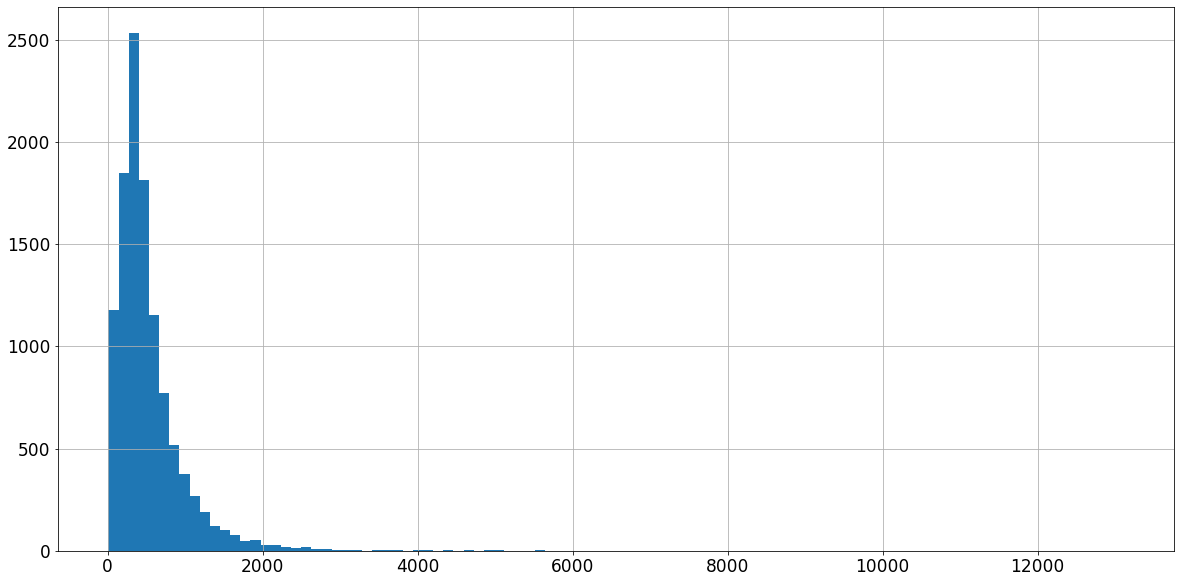

In [146]:
# plot the sequence lengths in a histogram

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 17})

hist = seq_df.length.hist(bins=100)

In [147]:
# 98% of sequences are between 1 and 2000 in length

print(len(seq_df[seq_df.length <= 2000]))
len(seq_df[seq_df.length <= 2000])/len(seq_df)

11057


0.9851211689237348

The FASTA files can contain either a reference to a specific amino acid or other codes. For more information on what the letters in FASTA files mean, see: https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=BlastHelp

In this dataset, we checked whether any of the sequences contained non-amino acid references, including:
- B: aspartate/asparagine  
- Z: glutamate/glutamine
- X: any
- *: translation stop
- -: gap of indeterminate length

In [149]:
# check for "X" 
seq_df.sequences.str.contains('X', regex=False).value_counts()

False    11169
True        55
Name: sequences, dtype: int64

There were 55 sequences with a X, accounting for 0.5% of the dataset. Replacing the X’s would be challenging, as they could mean any amino acid with equal probability, so sequences containing an X were removed.

In [150]:
# there are 55 with X, remove these 

seq_df = seq_df[seq_df["sequences"].str.contains("X", regex=False) == False]
seq_df = seq_df.reset_index()
seq_df

,index,sequences,length,location
0,0,"(M, G, Q, Q, V, G, R, V, G, E, A, P, G, L, Q, ...",1182,1
1,1,"(M, A, L, E, P, I, D, Y, T, T, H, S, R, E, I, ...",592,1
2,2,"(M, N, Q, I, E, P, G, V, Q, Y, N, Y, V, Y, D, ...",894,1
3,3,"(M, S, E, E, P, T, P, V, S, G, N, D, K, Q, L, ...",861,1
4,4,"(M, G, D, W, M, T, V, T, D, P, G, L, S, S, E, ...",614,1
...,...,...,...,...
11164,11219,"(M, I, P, N, I, T, Q, L, K, T, A, A, L, V, M, ...",353,4
11165,11220,"(M, L, R, K, L, V, T, G, A, L, A, A, A, L, L, ...",335,4
11166,11221,"(M, I, F, H, Q, F, Y, S, I, L, I, L, C, L, I, ...",200,4
11167,11222,"(M, K, F, Q, V, V, L, S, A, L, L, A, C, S, S, ...",354,4


In [151]:
# check they've been removed
seq_df.sequences.str.contains('X', regex=False).value_counts()

False    11169
Name: sequences, dtype: int64

In [152]:
# check for some other non-AA codes
seq_df.sequences.str.contains('B', regex=False).value_counts()

False    11168
True         1
Name: sequences, dtype: int64

In [153]:
seq_df.sequences.str.contains('Z', regex=False).value_counts()

False    11169
Name: sequences, dtype: int64

In [154]:
seq_df.sequences.str.contains('-', regex=False).value_counts()

False    11169
Name: sequences, dtype: int64

In [155]:
seq_df.sequences.str.contains('*', regex=False).value_counts()

False    11169
Name: sequences, dtype: int64

One sequence contained a B, this was replaced by a D for aspartate and has a 50% probability of being correct.

In [156]:
# only need to handle the one B - replce with Aspartate - D

print(seq_df.index[seq_df['sequences'].str.contains('B', regex=False)])

seq_with_b = str(seq_df.sequences[10678])

seq_with_b_replaced_d = seq_with_b.replace("B", "D")

seq_df.loc[10678,'sequences'] = seq_with_b_replaced_d

seq_df.sequences.str.contains('B', regex=False).value_counts()

Int64Index([10678], dtype='int64')


False    11169
Name: sequences, dtype: int64

## Feature Engineering

In this section, we created additional features to use for prediction.  

Features to be created:
- Sequence length  
- Global amino acid composition (i.e. percentages of all 20 amino acids present in whole sequence)  
- Local amino acid composition (i.e. over first 50 amino acids or last 50 amino acids) 
- Isoelectric point  
- Molecular weight  
- Presence of charged/uncharged/aromatic amino acids 

Additionally, we researched whether there are particular patterns of amino acids associated with certain locations and added features based on these. The following features were added:
- Significant associations with charged, Q, or N residues reach more extreme percent compositions in the nucleus [1]  
- Significant associations with P enrichment reach higher percent compositions in the cytoplasm [1]  
- Nucleus sequences: [2]
    - K (K/R) X (K/R)  
    - proline (P) and is followed by an amino acid sequence containing three basic residues out of four (PKLKR)  
    - R/K(X)10-12KRXK  
- Secretion:
    - Almost all proteins that are destined to the secretory pathway have a sequence consisting of 5-30 hydrophobic amino acids on the N-terminus, which is commonly referred to as the signal peptide, signal sequence or leader peptide. Signal peptides form alpha-helical structures. [3] -> 5 Hydrophobics at begining - http://www.russelllab.org/aas/hydrophobic.html
    - Summary: look for 5 of VILMFWCATHYGK  
- Mitochondria:
    - 15-70 amino acid long peptide that directs a newly synthesized protein to the mitochondria. It is found at the N-terminus end consists of an alternating pattern of hydrophobic and positively charged amino acids to form what is called an amphipathic helix. [3, 4] -> 15x hydrophibic then positively charged AA at begining - http://www.russelllab.org/aas/charged.html
    - Summary: Look for 15x alternating hydrophobic (VILMFWCATHYGK) then +ve charge (RKH) OR 15x +ve charge (RKH) then hydrophobic (VILMFWCATHYGK)  

Refs: 
1. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006256#pcbi-1006256-g009
2. https://biosignaling.biomedcentral.com/articles/10.1186/s12964-021-00741-y
3. https://en.wikipedia.org/wiki/Target_peptide
4. https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/mitochondrial-targeting-signal

In [157]:
mol_weight = []
get_amino_acids_percent = []
aromaticity = []
isoelectric_point = []
get_amino_acids_percent_subseq = []

for seq in seq_df.sequences:
    analysed_seq = ProteinAnalysis(str(seq))
    mol_weight.append(analysed_seq.molecular_weight())
    get_amino_acids_percent.append(analysed_seq.get_amino_acids_percent())
    aromaticity.append(analysed_seq.aromaticity())
    isoelectric_point.append(analysed_seq.isoelectric_point())
    # also look at N-term - start of protein 
    subseq = str(seq)[:50]
    analysed_subseq = ProteinAnalysis(subseq)
    get_amino_acids_percent_subseq.append(analysed_seq.get_amino_acids_percent())
    

In [158]:
len(mol_weight), len(get_amino_acids_percent), len(aromaticity), len(isoelectric_point), len(get_amino_acids_percent_subseq)

(11169, 11169, 11169, 11169, 11169)

In [160]:
# get sequences with targetting seq
nuc1 = []
nuc2 = []
nuc3 = []
sec = []
sec2 = []
mito = []

for s in seq_df.sequences:
    str_s = str(s)
    s1 = pd.Series([str_s])
    # print(str_s)
    
    if s1.str.contains('K(K|R).(K|R)K', na=False, regex=True)[0] == True:
        nuc1.append(1)
    else:
        nuc1.append(0)
    
    if (s1.str.contains('(P.(K|H|R){3})', na=False, regex=True)[0] == True) or  (s1.str.contains('(P(K|H|R).(K|H|R){2})', na=False, regex=True)[0] == True) or (s1.str.contains('(P(K|H|R){2}.(K|H|R))', na=False, regex=True)[0] == True) or (s1.str.contains('(P(K|H|R){3}.)', na=False, regex=True)[0] == True):
        nuc2.append(1)
    else:
        nuc2.append(0)
        
    if s1.str.contains('(R|K).{10,12}KR.K', na=False, regex=True)[0] == True:
        nuc3.append(1)
    else:
        nuc3.append(0)
    
    if s1.str.contains('^[V|I|L|M|F|W|C|A|T|H|Y|G|K]{5}', na=False, regex=True)[0] == True:
        sec.append(1)
    else:
        sec.append(0)
    
    if s1.str.contains('^.....[V|I|L|M|F|W|C|A|T|H|Y|G|K]{5}', na=False, regex=True)[0] == True:
        sec2.append(1)
    else:
        sec2.append(0)

    if s1.str.contains('^([V|I|L|M|F|W|C|A|T|H|Y|G|K][R|K|H]){7}', na=False, regex=True)[0] == True:
        mito.append(1)
    else:
        mito.append(0)
    

In [161]:
seq_df = seq_df.drop(columns=['index'])
seq_df['mol_weight'] = mol_weight
seq_df['aromaticity'] = aromaticity
seq_df['isoelectric_point'] = isoelectric_point
seq_df['nuc_seq_1'] = nuc1
seq_df['nuc_seq_2'] = nuc2
seq_df['nuc_seq_3'] = nuc3
# use the new feature
seq_df['sec_seq'] = sec2

# none of these display a mito seq therefore drop it 
# seq_df['mito_seq'] = mito
# seq_df = seq_df.drop(columns=['mito_seq'])

In [162]:
seq_df

,sequences,length,location,mol_weight,aromaticity,isoelectric_point,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq
0,"(M, G, Q, Q, V, G, R, V, G, E, A, P, G, L, Q, ...",1182,1,128194.9812,0.067682,7.965472,0,1,0,0
1,"(M, A, L, E, P, I, D, Y, T, T, H, S, R, E, I, ...",592,1,65575.3795,0.060811,4.589203,0,0,0,0
2,"(M, N, Q, I, E, P, G, V, Q, Y, N, Y, V, Y, D, ...",894,1,103852.5990,0.078300,5.307648,0,0,0,0
3,"(M, S, E, E, P, T, P, V, S, G, N, D, K, Q, L, ...",861,1,97356.5559,0.073171,5.001513,1,0,0,0
4,"(M, G, D, W, M, T, V, T, D, P, G, L, S, S, E, ...",614,1,71235.4260,0.061889,6.029389,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
11164,"(M, I, P, N, I, T, Q, L, K, T, A, A, L, V, M, ...",353,4,38164.4388,0.084986,5.142985,0,0,0,0
11165,"(M, L, R, K, L, V, T, G, A, L, A, A, A, L, L, ...",335,4,36093.7567,0.101493,9.017274,0,0,0,1
11166,"(M, I, F, H, Q, F, Y, S, I, L, I, L, C, L, I, ...",200,4,22967.3146,0.120000,4.375432,0,0,0,0
11167,"(M, K, F, Q, V, V, L, S, A, L, L, A, C, S, S, ...",354,4,37327.4851,0.079096,5.291392,0,0,0,0


In [166]:
global_aa_percent_df = pd.DataFrame.from_dict(get_amino_acids_percent)
global_aa_percent_df = global_aa_percent_df.rename(columns={'A': 'A_global', 'C': 'C_global', 'D': 'D_global', 'E': 'E_global', 'F': 'F_global', 'G': 'G_global', 'H': 'H_global', 'I': 'I_global', 'K': 'K_global', 'L': 'L_global', 'M': 'M_global', 'N': 'N_global', 'P': 'P_global', 'Q': 'Q_global', 'R': 'R_global', 'S': 'S_global', 'T': 'T_global', 'V': 'V_global', 'W': 'W_global', 'Y': 'Y_global'})


In [167]:
local_aa_percent_df = pd.DataFrame.from_dict(get_amino_acids_percent_subseq)
local_aa_percent_df = local_aa_percent_df.rename(columns={'A': 'A_local', 'C': 'C_local', 'D': 'D_local', 'E': 'E_local', 'F': 'F_local', 'G': 'G_local', 'H': 'H_local', 'I': 'I_local', 'K': 'K_local', 'L': 'L_local', 'M': 'M_local', 'N': 'N_local', 'P': 'P_local', 'Q': 'Q_local', 'R': 'R_local', 'S': 'S_local', 'T': 'T_local', 'V': 'V_local', 'W': 'W_local', 'Y': 'Y_local'})


In [168]:
local_global_aa = pd.concat([local_aa_percent_df, global_aa_percent_df], axis = 1)
local_global_aa

,A_local,C_local,D_local,E_local,F_local,G_local,H_local,I_local,K_local,L_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,0.082064,0.014382,0.043147,0.068528,0.029611,0.081218,0.021997,0.025381,0.060914,0.083756,...,0.018613,0.033841,0.081218,0.037225,0.053299,0.099831,0.061760,0.065144,0.010998,0.027073
1,0.094595,0.001689,0.079392,0.126689,0.028716,0.037162,0.006757,0.047297,0.099662,0.052365,...,0.008446,0.050676,0.111486,0.033784,0.028716,0.086149,0.037162,0.037162,0.013514,0.018581
2,0.083893,0.011186,0.060403,0.102908,0.031320,0.039150,0.025727,0.073826,0.059284,0.093960,...,0.032438,0.051454,0.031320,0.061521,0.067114,0.042506,0.048098,0.036913,0.017897,0.029083
3,0.078978,0.009292,0.067364,0.094077,0.038328,0.039489,0.019744,0.060395,0.084785,0.109175,...,0.012776,0.053426,0.019744,0.060395,0.031359,0.075494,0.054588,0.055749,0.012776,0.022067
4,0.032573,0.022801,0.053746,0.104235,0.024430,0.034202,0.021173,0.040717,0.089577,0.104235,...,0.027687,0.053746,0.022801,0.074919,0.055375,0.104235,0.052117,0.043974,0.013029,0.024430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11164,0.113314,0.005666,0.067989,0.050992,0.036827,0.076487,0.022663,0.048159,0.059490,0.090652,...,0.016997,0.045326,0.036827,0.039660,0.025496,0.084986,0.059490,0.070822,0.019830,0.028329
11165,0.062687,0.023881,0.032836,0.017910,0.020896,0.149254,0.005970,0.041791,0.044776,0.056716,...,0.014925,0.170149,0.020896,0.062687,0.029851,0.083582,0.056716,0.023881,0.032836,0.047761
11166,0.040000,0.005000,0.115000,0.075000,0.015000,0.120000,0.025000,0.060000,0.005000,0.015000,...,0.045000,0.055000,0.085000,0.055000,0.080000,0.090000,0.000000,0.010000,0.040000,0.065000
11167,0.093220,0.005650,0.036723,0.036723,0.036723,0.050847,0.005650,0.070621,0.048023,0.070621,...,0.002825,0.076271,0.048023,0.025424,0.014124,0.144068,0.084746,0.107345,0.005650,0.036723


In [169]:
seq_df = pd.concat([seq_df, local_global_aa], axis = 1)

In [170]:
seq_features_df = seq_df
seq_features_df = seq_features_df.drop(columns=['sequences'])
seq_features_df

,length,location,mol_weight,aromaticity,isoelectric_point,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,A_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,1182,1,128194.9812,0.067682,7.965472,0,1,0,0,0.082064,...,0.018613,0.033841,0.081218,0.037225,0.053299,0.099831,0.061760,0.065144,0.010998,0.027073
1,592,1,65575.3795,0.060811,4.589203,0,0,0,0,0.094595,...,0.008446,0.050676,0.111486,0.033784,0.028716,0.086149,0.037162,0.037162,0.013514,0.018581
2,894,1,103852.5990,0.078300,5.307648,0,0,0,0,0.083893,...,0.032438,0.051454,0.031320,0.061521,0.067114,0.042506,0.048098,0.036913,0.017897,0.029083
3,861,1,97356.5559,0.073171,5.001513,1,0,0,0,0.078978,...,0.012776,0.053426,0.019744,0.060395,0.031359,0.075494,0.054588,0.055749,0.012776,0.022067
4,614,1,71235.4260,0.061889,6.029389,1,1,0,0,0.032573,...,0.027687,0.053746,0.022801,0.074919,0.055375,0.104235,0.052117,0.043974,0.013029,0.024430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11164,353,4,38164.4388,0.084986,5.142985,0,0,0,0,0.113314,...,0.016997,0.045326,0.036827,0.039660,0.025496,0.084986,0.059490,0.070822,0.019830,0.028329
11165,335,4,36093.7567,0.101493,9.017274,0,0,0,1,0.062687,...,0.014925,0.170149,0.020896,0.062687,0.029851,0.083582,0.056716,0.023881,0.032836,0.047761
11166,200,4,22967.3146,0.120000,4.375432,0,0,0,0,0.040000,...,0.045000,0.055000,0.085000,0.055000,0.080000,0.090000,0.000000,0.010000,0.040000,0.065000
11167,354,4,37327.4851,0.079096,5.291392,0,0,0,0,0.093220,...,0.002825,0.076271,0.048023,0.025424,0.014124,0.144068,0.084746,0.107345,0.005650,0.036723


In [171]:
seq_features_df.describe()

,length,location,mol_weight,aromaticity,isoelectric_point,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,A_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
count,11169.000000,11169.000000,1.116900e+04,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,...,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000,11169.000000
mean,528.304862,1.947533,5.901523e+04,0.079154,7.191593,0.090966,0.246038,0.059092,0.137703,0.072491,...,0.021931,0.044472,0.053480,0.043118,0.055664,0.080057,0.053166,0.060845,0.011778,0.029697
std,476.405340,1.355150,5.295956e+04,0.029600,1.830855,0.287574,0.430720,0.235808,0.344603,0.033041,...,0.012209,0.023049,0.028643,0.021708,0.026621,0.030168,0.020197,0.022324,0.011239,0.016609
min,11.000000,0.000000,1.149250e+03,0.000000,4.050028,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,264.000000,1.000000,2.948841e+04,0.060031,5.591957,0.000000,0.000000,0.000000,0.000000,0.051282,...,0.014870,0.029412,0.036689,0.030303,0.040404,0.061033,0.042071,0.047072,0.005254,0.019169
50%,408.000000,2.000000,4.544330e+04,0.077203,6.730612,0.000000,0.000000,0.000000,0.000000,0.067024,...,0.020487,0.042529,0.048880,0.040724,0.052995,0.076923,0.051701,0.058824,0.009901,0.027972
75%,652.000000,3.000000,7.296417e+04,0.095238,8.918057,0.000000,0.000000,0.000000,0.000000,0.087805,...,0.027027,0.056140,0.064257,0.052747,0.067138,0.095930,0.062069,0.072000,0.015848,0.037855
max,13100.000000,4.000000,1.373285e+06,0.600000,11.999968,1.000000,1.000000,1.000000,1.000000,0.564220,...,0.272727,0.370130,0.607988,0.333333,0.628571,0.408719,0.266667,0.307692,0.533333,0.222222


## Create Train and Test Data

In this section we created the training and testing dataset, with a 90-10% split.

In [173]:
seq_features_df_np = seq_features_df.to_numpy()
seq_features_df_np.shape

seq_features_df_np[:,1]

array([1., 1., 1., ..., 4., 4., 4.])

In [174]:
X = np.delete(seq_features_df_np, 1, axis=1)
y = seq_features_df_np[:,1]

# split into training and test data, test data we don't look at until the end
X_train, test_data_X, y_train, test_data_y = train_test_split(X, y, test_size=0.1, random_state=42)
test_data_X.shape, test_data_y.shape, X_train.shape, y_train.shape

((1117, 48), (1117,), (10052, 48), (10052,))

In [175]:
np.count_nonzero(test_data_y == 0)/test_data_y.shape[0], np.count_nonzero(y_train == 0)/y_train.shape[0]

(0.18173679498657117, 0.1789693593314763)

In [176]:
np.count_nonzero(test_data_y == 1)/test_data_y.shape[0], np.count_nonzero(y_train == 1)/y_train.shape[0]

(0.2802148612354521, 0.267608436132113)

In [177]:
np.count_nonzero(test_data_y == 2)/test_data_y.shape[0], np.count_nonzero(y_train == 2)/y_train.shape[0]

(0.10743061772605192, 0.11709112614405094)

In [178]:
np.count_nonzero(test_data_y == 3)/test_data_y.shape[0], np.count_nonzero(y_train == 3)/y_train.shape[0]

(0.2855863921217547, 0.2978511738957421)

In [179]:
np.count_nonzero(test_data_y == 4)/test_data_y.shape[0], np.count_nonzero(y_train == 4)/y_train.shape[0]

(0.1450313339301701, 0.1384799044966176)

## Feature Processing - Standardisation

In this section, the training data was standardised.

In [180]:
# get X_train and y_train into a DF
cols = ['length',
 'mol_weight',
 'aromaticity',
 'isoelectric_point',
 'nuc_seq_1',
 'nuc_seq_2',
 'nuc_seq_3',
 'sec_seq',
 'A_local',
 'C_local',
 'D_local',
 'E_local',
 'F_local',
 'G_local',
 'H_local',
 'I_local',
 'K_local',
 'L_local',
 'M_local',
 'N_local',
 'P_local',
 'Q_local',
 'R_local',
 'S_local',
 'T_local',
 'V_local',
 'W_local',
 'Y_local',
 'A_global',
 'C_global',
 'D_global',
 'E_global',
 'F_global',
 'G_global',
 'H_global',
 'I_global',
 'K_global',
 'L_global',
 'M_global',
 'N_global',
 'P_global',
 'Q_global',
 'R_global',
 'S_global',
 'T_global',
 'V_global',
 'W_global',
 'Y_global']

training_df = pd.DataFrame(X_train, columns = cols)
training_df_y = pd.DataFrame(y_train, columns = ['location'])
training_df = pd.concat([training_df,training_df_y], axis=1)
training_df

,length,mol_weight,aromaticity,isoelectric_point,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,A_local,C_local,...,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global,location
0,802.0,85843.4110,0.033666,7.623439,0.0,0.0,0.0,0.0,0.091022,0.009975,...,0.033666,0.180798,0.052369,0.071072,0.109726,0.052369,0.043641,0.006234,0.013716,1.0
1,343.0,36786.9963,0.084548,8.922763,0.0,0.0,0.0,0.0,0.134111,0.002915,...,0.023324,0.064140,0.026239,0.096210,0.046647,0.055394,0.081633,0.037901,0.014577,0.0
2,5560.0,599992.8316,0.026619,8.815552,1.0,1.0,1.0,0.0,0.076079,0.008813,...,0.047302,0.080396,0.089928,0.051619,0.138669,0.062050,0.052338,0.001799,0.010432,3.0
3,647.0,73119.1079,0.092736,9.393833,0.0,0.0,0.0,1.0,0.072643,0.020093,...,0.041731,0.037094,0.046368,0.047913,0.069552,0.051005,0.052550,0.006182,0.037094,2.0
4,127.0,15001.4600,0.196850,8.529699,0.0,0.0,0.0,0.0,0.039370,0.015748,...,0.031496,0.015748,0.007874,0.047244,0.110236,0.062992,0.047244,0.023622,0.086614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,508.0,56691.7804,0.090551,8.646258,0.0,1.0,0.0,0.0,0.055118,0.029528,...,0.076772,0.068898,0.049213,0.045276,0.129921,0.059055,0.064961,0.007874,0.029528,3.0
10048,872.0,99002.4225,0.049312,9.375073,0.0,1.0,0.0,0.0,0.013761,0.009174,...,0.266055,0.059633,0.097477,0.022936,0.111239,0.042431,0.016055,0.004587,0.025229,3.0
10049,475.0,55425.9234,0.075789,5.213238,0.0,0.0,0.0,0.0,0.046316,0.010526,...,0.044211,0.048421,0.037895,0.052632,0.071579,0.037895,0.044211,0.016842,0.021053,3.0
10050,427.0,47850.6013,0.067916,6.363603,0.0,0.0,0.0,0.0,0.044496,0.025761,...,0.065574,0.039813,0.039813,0.044496,0.058548,0.063232,0.072600,0.009368,0.030445,1.0


In [181]:
# select the cols we want to standardise 
standardised_features_df = training_df
standardised_features_df = standardised_features_df.drop(columns=['location', 'nuc_seq_1', 'nuc_seq_2', 'nuc_seq_3', 'sec_seq'])
standardised_features_df

,length,mol_weight,aromaticity,isoelectric_point,A_local,C_local,D_local,E_local,F_local,G_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,802.0,85843.4110,0.033666,7.623439,0.091022,0.009975,0.026185,0.077307,0.013716,0.054863,...,0.014963,0.033666,0.180798,0.052369,0.071072,0.109726,0.052369,0.043641,0.006234,0.013716
1,343.0,36786.9963,0.084548,8.922763,0.134111,0.002915,0.046647,0.049563,0.032070,0.128280,...,0.008746,0.023324,0.064140,0.026239,0.096210,0.046647,0.055394,0.081633,0.037901,0.014577
2,5560.0,599992.8316,0.026619,8.815552,0.076079,0.008813,0.042086,0.055396,0.014388,0.059892,...,0.018165,0.047302,0.080396,0.089928,0.051619,0.138669,0.062050,0.052338,0.001799,0.010432
3,647.0,73119.1079,0.092736,9.393833,0.072643,0.020093,0.049459,0.049459,0.049459,0.052550,...,0.013910,0.041731,0.037094,0.046368,0.047913,0.069552,0.051005,0.052550,0.006182,0.037094
4,127.0,15001.4600,0.196850,8.529699,0.039370,0.015748,0.039370,0.031496,0.086614,0.039370,...,0.047244,0.031496,0.015748,0.007874,0.047244,0.110236,0.062992,0.047244,0.023622,0.086614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,508.0,56691.7804,0.090551,8.646258,0.055118,0.029528,0.033465,0.035433,0.053150,0.033465,...,0.027559,0.076772,0.068898,0.049213,0.045276,0.129921,0.059055,0.064961,0.007874,0.029528
10048,872.0,99002.4225,0.049312,9.375073,0.013761,0.009174,0.034404,0.029817,0.019495,0.027523,...,0.012615,0.266055,0.059633,0.097477,0.022936,0.111239,0.042431,0.016055,0.004587,0.025229
10049,475.0,55425.9234,0.075789,5.213238,0.046316,0.010526,0.075789,0.132632,0.037895,0.033684,...,0.021053,0.044211,0.048421,0.037895,0.052632,0.071579,0.037895,0.044211,0.016842,0.021053
10050,427.0,47850.6013,0.067916,6.363603,0.044496,0.025761,0.044496,0.063232,0.028103,0.067916,...,0.021077,0.065574,0.039813,0.039813,0.044496,0.058548,0.063232,0.072600,0.009368,0.030445


In [182]:
standardised_features_df_numpy = normalised_features_df.to_numpy()
standardised_features_df_numpy.shape

(10052, 44)

In [183]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(standardised_features_df_numpy)
# scaler.data_max_
standardised_data = scaler.transform(standardised_features_df_numpy)

In [184]:
standardised_data.shape

(10052, 44)

In [185]:
standardised_features_df_2 = pd.DataFrame(standardised_data, columns = list(standardised_features_df.columns.values))
standardised_features_df_2

,length,mol_weight,aromaticity,isoelectric_point,A_local,C_local,D_local,E_local,F_local,G_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,0.578619,0.510463,-1.559860,0.236532,0.565367,-0.357295,-1.291486,0.353739,-1.403888,-0.285979,...,-0.568594,-0.470179,4.440589,0.431529,0.580748,0.985300,-0.038078,-0.772329,-0.543342,-0.965996
1,-0.387250,-0.418154,0.187560,0.946086,1.879947,-0.621957,-0.320247,-0.602983,-0.330744,2.143652,...,-1.072172,-0.919214,0.371510,-0.776016,1.527549,-1.109914,0.113551,0.925377,2.578832,-0.913650
2,10.590828,10.243085,-1.801875,0.887539,0.109463,-0.400862,-0.536725,-0.401838,-1.364552,-0.119544,...,-0.309129,0.121878,0.938517,2.167240,-0.151968,1.946683,0.447277,-0.383683,-0.980697,-1.165531
3,0.252454,0.269597,0.468742,1.203336,0.004629,0.022013,-0.186787,-0.606557,0.685966,-0.362512,...,-0.653836,-0.120006,-0.571853,0.154194,-0.291526,-0.349117,-0.106482,-0.374205,-0.548472,0.454453
4,-0.841777,-0.830544,4.044291,0.731436,-1.010491,-0.140868,-0.665649,-1.225990,2.858366,-0.798690,...,2.046532,-0.564385,-1.316419,-1.624720,-0.316737,1.002257,0.494491,-0.611316,1.171003,3.463211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,-0.040042,-0.041365,0.393720,0.795088,-0.530036,0.375721,-0.945948,-1.090226,0.901747,-0.994124,...,0.451846,1.401374,0.537460,0.285658,-0.390880,1.656116,0.297116,0.180368,-0.381684,-0.005291
10048,0.725919,0.759557,-1.022535,1.193091,-1.791783,-0.387315,-0.901374,-1.283907,-1.065958,-1.190754,...,-0.758799,9.619612,0.214307,2.516102,-1.232303,1.035550,-0.536297,-2.005034,-0.705754,-0.266443
10049,-0.109484,-0.065327,-0.113233,-1.079667,-0.798585,-0.336628,1.062958,2.261554,0.009820,-0.986855,...,-0.075240,-0.012353,-0.176771,-0.237373,-0.113818,-0.281783,-0.763725,-0.746874,0.502530,-0.520215
10050,-0.210490,-0.208725,-0.383637,-0.451459,-0.854090,0.234519,-0.422329,-0.131617,-0.562684,0.145986,...,-0.073243,0.915188,-0.477036,-0.148741,-0.420224,-0.714618,0.506509,0.521721,-0.234415,0.050450


In [186]:
# add the standardised back to the rest of the data 
features_df = training_df[['location', 'nuc_seq_1', 'nuc_seq_2', 'nuc_seq_3', 'sec_seq']]
features_df = pd.concat([features_df,standardised_features_df_2], axis=1)

features_df

,location,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,length,mol_weight,aromaticity,isoelectric_point,A_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,1.0,0.0,0.0,0.0,0.0,0.578619,0.510463,-1.559860,0.236532,0.565367,...,-0.568594,-0.470179,4.440589,0.431529,0.580748,0.985300,-0.038078,-0.772329,-0.543342,-0.965996
1,0.0,0.0,0.0,0.0,0.0,-0.387250,-0.418154,0.187560,0.946086,1.879947,...,-1.072172,-0.919214,0.371510,-0.776016,1.527549,-1.109914,0.113551,0.925377,2.578832,-0.913650
2,3.0,1.0,1.0,1.0,0.0,10.590828,10.243085,-1.801875,0.887539,0.109463,...,-0.309129,0.121878,0.938517,2.167240,-0.151968,1.946683,0.447277,-0.383683,-0.980697,-1.165531
3,2.0,0.0,0.0,0.0,1.0,0.252454,0.269597,0.468742,1.203336,0.004629,...,-0.653836,-0.120006,-0.571853,0.154194,-0.291526,-0.349117,-0.106482,-0.374205,-0.548472,0.454453
4,1.0,0.0,0.0,0.0,0.0,-0.841777,-0.830544,4.044291,0.731436,-1.010491,...,2.046532,-0.564385,-1.316419,-1.624720,-0.316737,1.002257,0.494491,-0.611316,1.171003,3.463211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,3.0,0.0,1.0,0.0,0.0,-0.040042,-0.041365,0.393720,0.795088,-0.530036,...,0.451846,1.401374,0.537460,0.285658,-0.390880,1.656116,0.297116,0.180368,-0.381684,-0.005291
10048,3.0,0.0,1.0,0.0,0.0,0.725919,0.759557,-1.022535,1.193091,-1.791783,...,-0.758799,9.619612,0.214307,2.516102,-1.232303,1.035550,-0.536297,-2.005034,-0.705754,-0.266443
10049,3.0,0.0,0.0,0.0,0.0,-0.109484,-0.065327,-0.113233,-1.079667,-0.798585,...,-0.075240,-0.012353,-0.176771,-0.237373,-0.113818,-0.281783,-0.763725,-0.746874,0.502530,-0.520215
10050,1.0,0.0,0.0,0.0,0.0,-0.210490,-0.208725,-0.383637,-0.451459,-0.854090,...,-0.073243,0.915188,-0.477036,-0.148741,-0.420224,-0.714618,0.506509,0.521721,-0.234415,0.050450


In [187]:
training_df

,length,mol_weight,aromaticity,isoelectric_point,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,A_local,C_local,...,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global,location
0,802.0,85843.4110,0.033666,7.623439,0.0,0.0,0.0,0.0,0.091022,0.009975,...,0.033666,0.180798,0.052369,0.071072,0.109726,0.052369,0.043641,0.006234,0.013716,1.0
1,343.0,36786.9963,0.084548,8.922763,0.0,0.0,0.0,0.0,0.134111,0.002915,...,0.023324,0.064140,0.026239,0.096210,0.046647,0.055394,0.081633,0.037901,0.014577,0.0
2,5560.0,599992.8316,0.026619,8.815552,1.0,1.0,1.0,0.0,0.076079,0.008813,...,0.047302,0.080396,0.089928,0.051619,0.138669,0.062050,0.052338,0.001799,0.010432,3.0
3,647.0,73119.1079,0.092736,9.393833,0.0,0.0,0.0,1.0,0.072643,0.020093,...,0.041731,0.037094,0.046368,0.047913,0.069552,0.051005,0.052550,0.006182,0.037094,2.0
4,127.0,15001.4600,0.196850,8.529699,0.0,0.0,0.0,0.0,0.039370,0.015748,...,0.031496,0.015748,0.007874,0.047244,0.110236,0.062992,0.047244,0.023622,0.086614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,508.0,56691.7804,0.090551,8.646258,0.0,1.0,0.0,0.0,0.055118,0.029528,...,0.076772,0.068898,0.049213,0.045276,0.129921,0.059055,0.064961,0.007874,0.029528,3.0
10048,872.0,99002.4225,0.049312,9.375073,0.0,1.0,0.0,0.0,0.013761,0.009174,...,0.266055,0.059633,0.097477,0.022936,0.111239,0.042431,0.016055,0.004587,0.025229,3.0
10049,475.0,55425.9234,0.075789,5.213238,0.0,0.0,0.0,0.0,0.046316,0.010526,...,0.044211,0.048421,0.037895,0.052632,0.071579,0.037895,0.044211,0.016842,0.021053,3.0
10050,427.0,47850.6013,0.067916,6.363603,0.0,0.0,0.0,0.0,0.044496,0.025761,...,0.065574,0.039813,0.039813,0.044496,0.058548,0.063232,0.072600,0.009368,0.030445,1.0


## Split Data and Upsample

The dataset is slightly imbalanced, with approximately 26% of the dataset containing cytosolic proteins, 12% mitochondrial pro- teins, 30% nucleic proteins, 14% secreted proteins and 18% prokaryotic proteins. 

In this section we considered balancing the dataset through resampling strategies, such as the Synthetic Minority Oversampling Technique (SMOTE). However, it was eventually decided not to resample the training data due to overfitting.

In [188]:
features_df.to_csv("data/features_df.csv", index=False)
seq_df.to_csv("data/seq_df.csv", index=False)

In [189]:
features_df_numpy = features_df.to_numpy()
features_df_numpy.shape

features_df_numpy[:,0]

array([1., 0., 3., ..., 3., 1., 3.])

In [190]:
X_train = np.delete(features_df_numpy, 0, axis=1)
y_train = features_df_numpy[:,0]

X_train.shape, y_train.shape

((10052, 48), (10052,))

In [191]:
# upsample X_train and y_train

# SMOTE NC
# sm = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 3])
# X_res, y_res = sm.fit_resample(X_train, y_train)
# X_res.shape

# sme = SMOTETomek(random_state=42)
# X_res, y_res = sme.fit_resample(X, y)

X_res = X_train
y_res = y_train

# ADASYN - didn't upsample properly (one was 34%), lower accuracy
# sm = ADASYN(random_state=42, sampling_strategy='minority')
# X_res, y_res = sm.fit_resample(X, y)
# X_res2, y_res2 = sm.fit_resample(X_res, y_res)
# X_res3, y_res3 = sm.fit_resample(X_res2, y_res2)
# X_res.shape

# BorderlineSMOTE - maybe oh so slightly better
# sm = BorderlineSMOTE(random_state=42, k_neighbors=10, m_neighbors=15)
# X_res, y_res = sm.fit_resample(X, y)
# X_res.shape

# KMeansSMOTE - similar to SMOTE
# sm = KMeansSMOTE(random_state=42, k_neighbors = 20)
# X_res, y_res = sm.fit_resample(X, y)

# SVMSMOTE - again, similar to SMOTE
# sm = SVMSMOTE(random_state=42, k_neighbors=10, m_neighbors=15)
# X_res, y_res = sm.fit_resample(X, y)

In [192]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [56]:
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((8041, 48), (2011, 48), (8041,), (2011,))

Check distribution in train and test is similar

In [57]:
np.count_nonzero(y_test_2 == 0)/y_test_2.shape[0], np.count_nonzero(y_train_2 == 0)/y_train_2.shape[0]

(0.18349080059671805, 0.17783857729138167)

In [58]:
np.count_nonzero(y_test_2 == 1)/y_test_2.shape[0], np.count_nonzero(y_train_2 == 1)/y_train_2.shape[0]

(0.2675285927399304, 0.26762840442731006)

In [59]:
np.count_nonzero(y_test_2 == 2)/y_test_2.shape[0], np.count_nonzero(y_train_2 == 2)/y_train_2.shape[0]

(0.11884634510193934, 0.11665215769182938)

In [60]:
np.count_nonzero(y_test_2 == 3)/y_test_2.shape[0], np.count_nonzero(y_train_2 == 3)/y_train_2.shape[0]

(0.2978617603182496, 0.29784852630269865)

In [61]:
np.count_nonzero(y_test_2 == 4)/y_test_2.shape[0], np.count_nonzero(y_train_2 == 4)/y_train_2.shape[0]

(0.13227250124316262, 0.14003233428678025)

## Feature Selection

Feature selection was conducted to remove redundant features that do not improve model performance, thus increasing computational efficiency.

Two methods to try:
1. Sequential Feature Selection 
2. Recursive feature elimination 

https://scikit-learn.org/stable/modules/feature_selection.html

The best 30, 35, 40 and 45 features were selected. The best features were then tested using a range of algorithms, including the MLP and Random Forest. An accuracy reduction of 1-3% was noted with all feature subsets. This is not a very large reduction and if the computational time to run the model with all features was high, it would have been considered to use a subset. However, as all features did contribute to model accuracy and the models ran with all features in a relatively short time period, it was decided to retain all of the features.

### Recursive Feature Selection 

RF with 3-fold CV:
- F1 score: 0.752
- AUC: 0.94
- Corr Coeff: 0.69

In [ ]:
estimator = SVC(probability=False, kernel="linear")
selector = RFECV(estimator, step=1, cv=2)
selector = selector.fit(X_res, y_res)

In [171]:
support = selector.support_
support 

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True])

In [172]:
ranking = selector.ranking_
ranking

array([ 9,  7,  6, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  3,  1,  1,  5,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1])

In [159]:
X_res[:,3]

array([0., 0., 0., ..., 0., 0., 1.])

In [218]:
X_res_feat_select = X_res
X_res_feat_select = np.delete(X_res_feat_select, [0,1,2,3,15,27,37,40,48], axis=1)
X_res_feat_select.shape

(16235, 42)

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=7)
kf.get_n_splits(X_res_feat_select)

print('=' * 80)
print("MLP")

i = 1

for train_index, test_index in kf.split(X_res_feat_select):
    X_train, X_test = X_res_feat_select[train_index], X_res_feat_select[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = MLPClassifier(random_state=1, max_iter=300, alpha=1.05)
    name = 'MLP'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

### Sequential Feature Selection

- k = 30, 3 fold CV: 
    - F1: 61%
    - AUC: 0.88
    - Corr Co-eff: 0.50
- k = 35, 3 fold CV: 
    - F1: 62.3%
    - AUC: 0.88
    - Corr Co-eff: 0.51
- k = 40, 3 fold CV: 
    - F1: 62.6%
    - AUC: 0.88
    - Corr Co-eff: 0.52
- k = 45, 3 fold CV: 
    - F1: 63%
    - AUC: 0.88
    - Corr Co-eff: 0.52
- k = 50, 3 fold CV: 
    - F1: 63.3%
    - AUC: 0.88
    - Corr Co-eff: 0.53

With all of them, 3 fold CV: 
- F1: 64 
- AUC: 0.88
- Corr Co-eff: 0.53

In [61]:
X_new = SelectKBest(k=30).fit_transform(X_res, y_res)
X_new.shape

(8935, 50)

In [64]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_new)

print('=' * 80)
print("SVM")

i = 1
for train_index, test_index in kf.split(X_new):
    X_train, X_test = X_new[train_index], X_new[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = SVC(probability=True, random_state=42, kernel="rbf", gamma="scale", decision_function_shape="ovo", C=2)
    name = 'SVM'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

SVM
Fold  1

accuracy:   0.658

classification report:
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83       338
         1.0       0.53      0.60      0.56       466
         2.0       0.54      0.50      0.52       179
         3.0       0.65      0.62      0.63       538
         4.0       0.85      0.68      0.76       266

    accuracy                           0.66      1787
   macro avg       0.67      0.65      0.66      1787
weighted avg       0.66      0.66      0.66      1787

confusion matrix:
[[293  17  14   7   7]
 [ 22 279  26 130   9]
 [ 13  39  90  30   7]
 [ 19 153  26 332   8]
 [ 22  36  11  15 182]]

AUC metric:
0.8950119074472207

Matthews correlation coefficient:
0.5573006219033413
Fold  2

accuracy:   0.643

classification report:
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.81       304
         1.0       0.52      0.56      0.54       499
         2.0       0.5

In [165]:
kf = KFold(n_splits=3, shuffle=True, random_state=7)
kf.get_n_splits(X_new)

print('=' * 80)
print("MLP")

i = 1

for train_index, test_index in kf.split(X_new):
    X_train, X_test = X_new[train_index], X_new[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    # clf = MLPClassifier(random_state=1, max_iter=300, alpha=1.05)
    clf = MLPClassifier(random_state=1, max_iter=300, alpha=1, solver='adam', learning_rate_init=0.001, learning_rate='constant', early_stopping=False, activation='relu')
    name = 'MLP'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

MLP
Fold  1

accuracy:   0.640

classification report:
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.81       535
         1.0       0.54      0.51      0.53       800
         2.0       0.58      0.50      0.54       322
         3.0       0.61      0.69      0.64       896
         4.0       0.77      0.64      0.70       426

    accuracy                           0.64      2979
   macro avg       0.65      0.64      0.64      2979
weighted avg       0.64      0.64      0.64      2979

confusion matrix:
[[450  31  15  25  14]
 [ 37 409  46 281  27]
 [ 30  54 162  54  22]
 [ 27 198  39 615  17]
 [ 39  60  19  36 272]]

AUC metric:
0.8825358365552619

Matthews correlation coefficient:
0.5328122174959345
Fold  2

accuracy:   0.625

classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       525
         1.0       0.51      0.54      0.52       793
         2.0       0.5

## Model Training

Here, two approaches were tested:
1. The problem could be treated as a multi-class classification problem, where one of five classes must be predicted (Prokaryotic, Cytosolic, Nucleic, Mitochondrial or Secreted). 
2. Alternatively, the problem could be treated as a combination of two approaches, a binary classification problem to classify proteins as prokaryotic or eukaryotic, followed by a multi-class classification of eu- karyotic proteins as one of the four remaining classes (Cytosolic, Nucleic, Mitochondrial or Secreted). 

For each model trained, we did the following:
1. Hyperparameter optimisation (HPO) using a halving random search.
2. Model training and validation using 5-fold cross validation. The following metrics were calculated: Precision, Recall, F1 Score, the confusion matrix, Area Under the ROC Curve score and Matthew’s Correlation Co-efficient. 

## Approach 1: Multi-Class Model

In [193]:
def algorithm(clf, name):
    # fit the data to the model
    clf.fit(X_train, y_train)
    
    # need to persist the model for later
    modelname = name
    
    # make predictions using the test input data
    pred = clf.predict(X_test)
    
    # compute some metrics to assess the accuracy of the predictions using this algorithm
    score = metrics.accuracy_score(y_test, pred)
    class_report = metrics.classification_report(y_test, pred)
    
    # A breakdown of predictions into a table showing correct predictions (the diagonal) 
    # and the types of incorrect predictions made (what classes incorrect predictions were assigned).
    confusionmtx = metrics.confusion_matrix(y_test, pred)
    
    pred_proba = clf.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, pred_proba, multi_class="ovr") # try ovo - same
    
    matthews_coeff = matthews_corrcoef(y_test, pred)
    
    # return the metrics 
    return score, class_report, confusionmtx, auc_score, matthews_coeff, pred

### Random Forest

#### HPO

In [63]:
clf = RandomForestClassifier(random_state=42)
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [64]:
param_dist = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, None],
    "max_features": randint(1, 6),
    "min_samples_split": randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=42
)
rsh.fit(X_res, y_res)

HalvingRandomSearchCV(estimator=RandomForestClassifier(random_state=42),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f914408fb80>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f91440d6f70>,
                                           'n_estimators': [50, 100, 150]},
                      random_state=42)

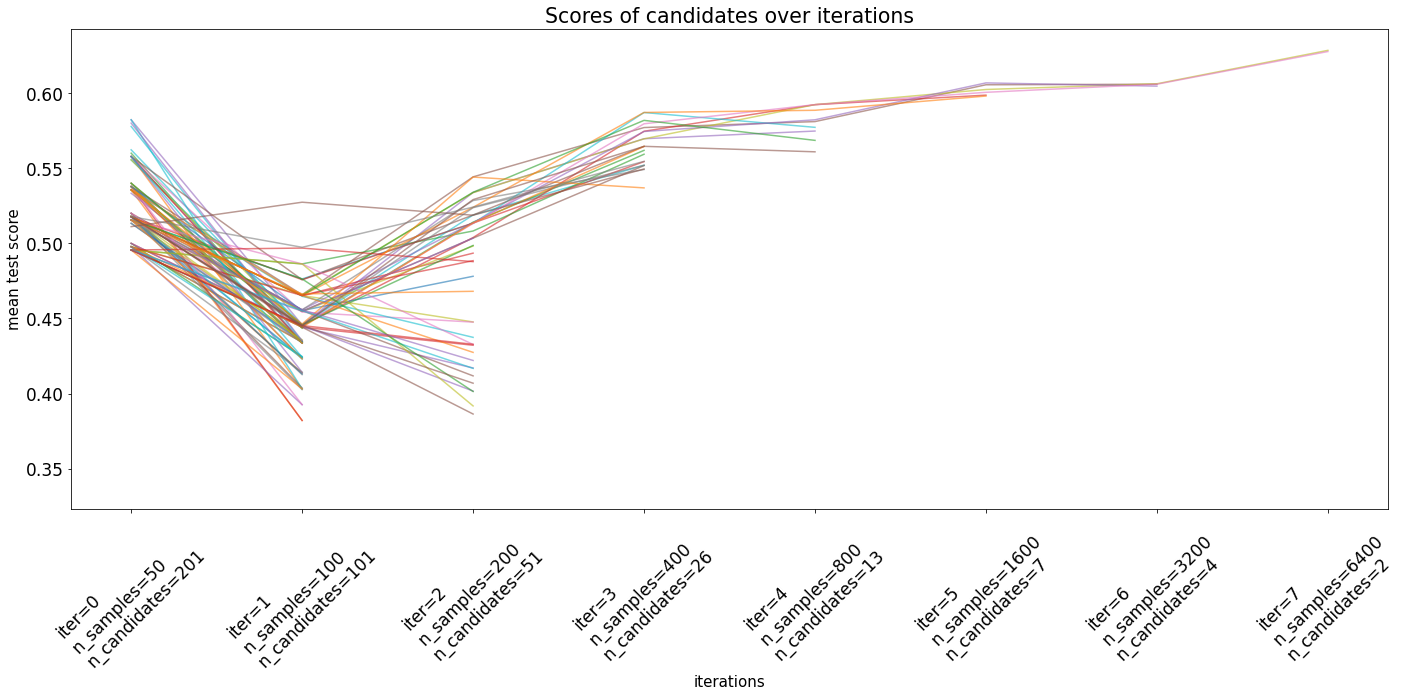

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 3,
 'min_samples_split': 8,
 'n_estimators': 150}

In [65]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

#### Run with optimal hyperparams

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res)

print('=' * 80)
print("Random Forest")

i = 1

for train_index, test_index in kf.split(X_res):
    X_train, X_test = X_res[train_index], X_res[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = RandomForestClassifier(bootstrap= False, criterion='entropy', max_depth= None, max_features=3, min_samples_split=8, n_estimators= 150, random_state=42)
    # clf = RandomForestClassifier(n_estimators= 20, random_state=42, max_depth= 10)

    name = 'Random Forest'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

Random Forest
Fold  1

accuracy:   0.643

classification report:
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83       362
         1.0       0.53      0.51      0.52       533
         2.0       0.57      0.38      0.45       231
         3.0       0.60      0.71      0.65       604
         4.0       0.81      0.68      0.74       281

    accuracy                           0.64      2011
   macro avg       0.66      0.63      0.64      2011
weighted avg       0.64      0.64      0.64      2011

confusion matrix:
[[314  27   8  11   2]
 [ 25 274  24 190  20]
 [ 21  63  87  49  11]
 [ 20 121  24 427  12]
 [ 15  33  10  31 192]]

AUC metric:
0.8919235383183122

Matthews correlation coefficient:
0.53599885343478
Fold  2

accuracy:   0.630

classification report:
              precision    recall  f1-score   support

         0.0       0.75      0.87      0.81       348
         1.0       0.52      0.52      0.52       539
         2.0  

<AxesSubplot:>

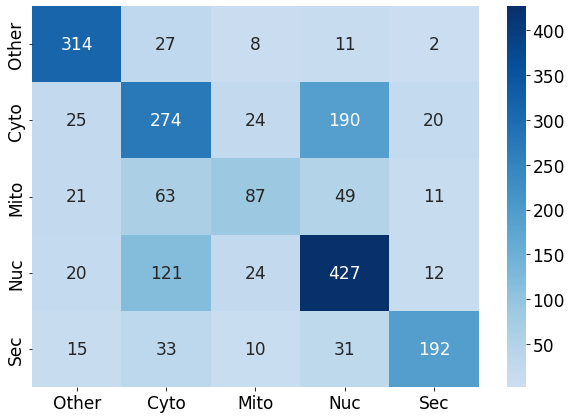

In [67]:
# plot confusion mtx

mtx1 = [[314,  27,   8,  11,   2],
 [ 25, 274,  24, 190,  20],
 [ 21,  63,  87,  49,  11],
 [ 20, 121,  24, 427,  12],
 [ 15,  33,  10,  31, 192]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((314-8)/2), fmt="d", cmap="Blues")

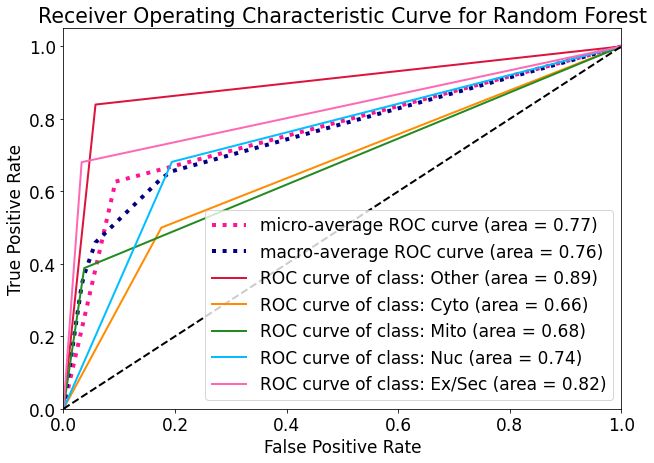

In [68]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Other", "Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[0, 1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve for Random Forest")
plt.legend(loc="lower right")
plt.show()

### Gradient Boosted Trees

#### HPO

In [89]:
clf = GradientBoostingClassifier(random_state=42)
clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [90]:
param_dist = {
    "learning_rate": [0.1, 0.2, 0.3],
    "subsample": [1.0, 0.7, 0.5],
    "criterion": ["friedman_mse", "squared_error"], 
    "n_estimators": [50, 100],
    "max_depth": [3, 1],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": randint(2, 11)
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=42
)
rsh.fit(X_res, y_res)

HalvingRandomSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                      factor=2,
                      param_distributions={'criterion': ['friedman_mse',
                                                         'squared_error'],
                                           'learning_rate': [0.1, 0.2, 0.3],
                                           'max_depth': [3, 1],
                                           'max_features': ['auto', 'sqrt',
                                                            'log2'],
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff021ac11c0>,
                                           'n_estimators': [50, 100],
                                           'subsample': [1.0, 0.7, 0.5]},
                      random_state=42)

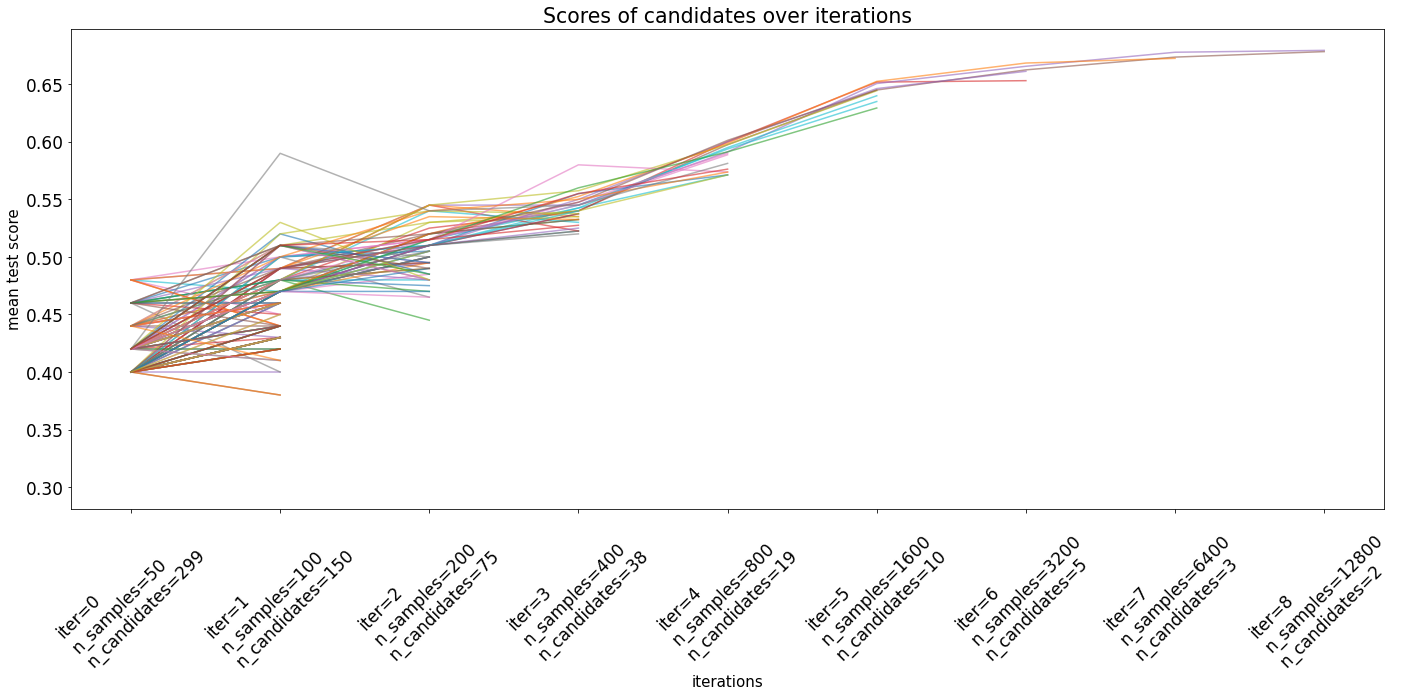

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_split': 5,
 'n_estimators': 100,
 'subsample': 1.0}

In [91]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

#### Run with optimal hyperparams

In [206]:
kf = KFold(n_splits=3, shuffle=True, random_state=7)
kf.get_n_splits(X_res)

print('=' * 80)
print("Gradient Boosted Trees")

i = 1

for train_index, test_index in kf.split(X_res):
    X_train, X_test = X_res[train_index], X_res[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    # clf = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, max_depth=3, random_state=42, max_features='log2', min_samples_split=5, n_estimators=100, subsample=1)
    clf = GradientBoostingClassifier(max_depth=2, random_state=42, n_estimators=100)
    name = 'Gradient Boosted Trees'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

 

Gradient Boosted Trees
Fold  1

accuracy:   0.619

classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       535
         1.0       0.51      0.53      0.52       800
         2.0       0.52      0.49      0.51       322
         3.0       0.60      0.62      0.61       896
         4.0       0.80      0.60      0.68       426

    accuracy                           0.62      2979
   macro avg       0.64      0.62      0.62      2979
weighted avg       0.62      0.62      0.62      2979

confusion matrix:
[[452  39  16  23   5]
 [ 41 425  52 256  26]
 [ 32  62 159  52  17]
 [ 32 245  49 553  17]
 [ 38  67  28  38 255]]

AUC metric:
0.8755205386683329

Matthews correlation coefficient:
0.5052698200677115
Fold  2

accuracy:   0.612

classification report:
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78       525
         1.0       0.48      0.49      0.48       793
   

<AxesSubplot:>

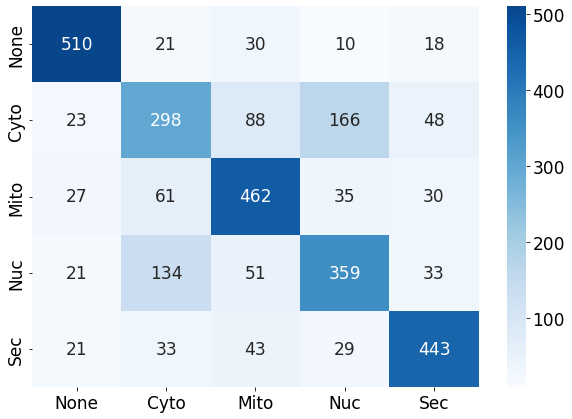

In [108]:
# plot confusion mtx

mtx1 = [[510,  21,  30,  10,  18],
 [ 23, 298,  88, 166,  48],
 [ 27,  61, 462,  35,  30],
 [ 21, 134,  51, 359,  33],
 [ 21,  33,  43,  29, 443]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["None", "Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["None", "Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((571-5)/2), fmt="d", cmap="Blues")

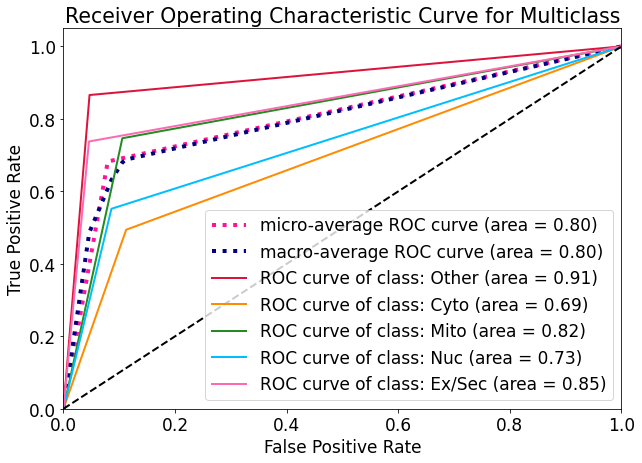

In [109]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Other", "Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[0, 1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()

### kNN

#### HPO

In [69]:
clf = KNeighborsClassifier()
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [70]:
param_dist = {
    "n_neighbors": [5, 10, 15, 20, 25],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2]
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=42
)
rsh.fit(X_res, y_res)

/Users/shabri/opt/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 80 is smaller than n_iter=201. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(estimator=KNeighborsClassifier(), factor=2,
                      param_distributions={'algorithm': ['auto', 'ball_tree',
                                                         'kd_tree', 'brute'],
                                           'n_neighbors': [5, 10, 15, 20, 25],
                                           'p': [1, 2],
                                           'weights': ['uniform', 'distance']},
                      random_state=42)

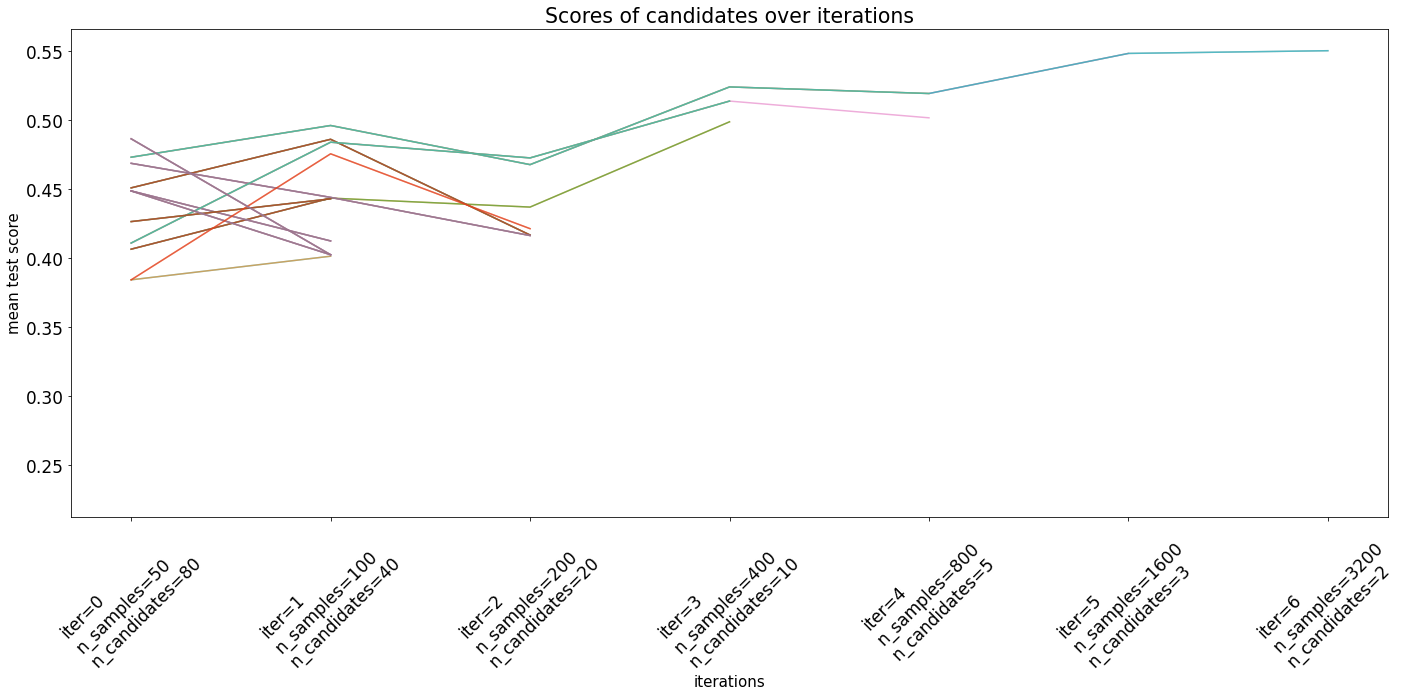

{'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'algorithm': 'ball_tree'}

In [71]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

#### Run with optimal hyperparams

In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res)

print('=' * 80)
print("kNN")

i = 1
for train_index, test_index in kf.split(X_res):
    X_train, X_test = X_res[train_index], X_res[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1, algorithm='ball_tree')
    name = 'kNN'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

kNN
Fold  1

accuracy:   0.604

classification report:
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       362
         1.0       0.50      0.55      0.52       533
         2.0       0.45      0.47      0.46       231
         3.0       0.59      0.63      0.61       604
         4.0       0.82      0.53      0.64       281

    accuracy                           0.60      2011
   macro avg       0.63      0.59      0.61      2011
weighted avg       0.62      0.60      0.61      2011

confusion matrix:
[[284  30  18  19  11]
 [ 24 293  47 158  11]
 [ 12  60 109  43   7]
 [ 19 153  48 380   4]
 [ 17  49  22  44 149]]

AUC metric:
0.8310282690396112

Matthews correlation coefficient:
0.48592911741767775
Fold  2

accuracy:   0.589

classification report:
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78       348
         1.0       0.48      0.56      0.52       539
         2.0       0.

<AxesSubplot:>

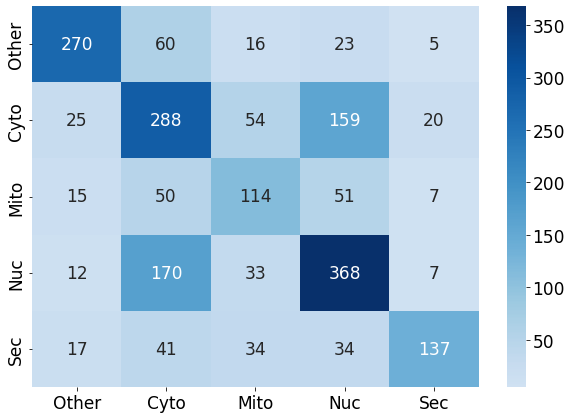

In [73]:
# plot confusion mtx

mtx1 = [[270,  60,  16,  23,   5],
 [ 25, 288,  54, 159,  20],
 [ 15,  50, 114,  51,   7],
 [ 12, 170,  33, 368,   7],
 [ 17,  41,  34,  34, 137]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((288-7)/2), fmt="d", cmap="Blues")

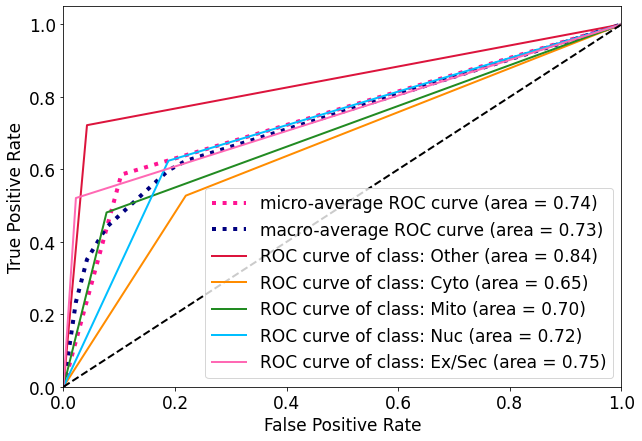

In [75]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Other", "Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[0, 1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()

### SVM

#### HPO

In [76]:
clf = SVC(random_state=42)
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [77]:
param_dist = {
    "kernel": ["poly", "rbf", "sigmoid"],
    "C": [1.0, 1.5, 2.0],
    "gamma": ["scale", "auto"], 
    "decision_function_shape": ["ovo", "ovr"]
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=42
)
rsh.fit(X_res, y_res)

/Users/shabri/opt/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=201. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(estimator=SVC(random_state=42), factor=2,
                      param_distributions={'C': [1.0, 1.5, 2.0],
                                           'decision_function_shape': ['ovo',
                                                                       'ovr'],
                                           'gamma': ['scale', 'auto'],
                                           'kernel': ['poly', 'rbf',
                                                      'sigmoid']},
                      random_state=42)

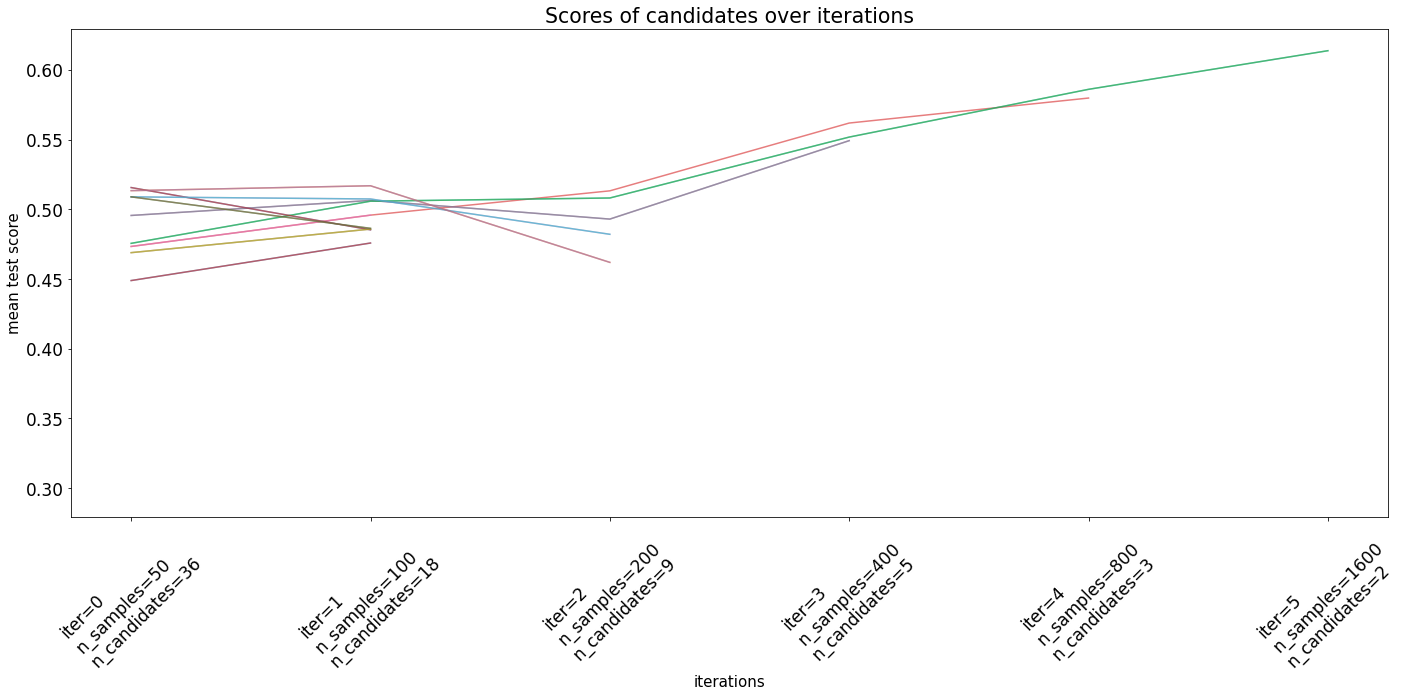

{'kernel': 'rbf', 'gamma': 'scale', 'decision_function_shape': 'ovr', 'C': 1.5}

In [78]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

#### Run with optimal hyperparams

In [194]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res)

print('=' * 80)
print("SVM")

i = 1
for train_index, test_index in kf.split(X_res):
    X_train, X_test = X_res[train_index], X_res[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = SVC(probability=True, random_state=42, kernel="rbf", gamma="scale", decision_function_shape="ovo", C=1.5)
    name = 'SVM'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

SVM
Fold  1

accuracy:   0.664

classification report:
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85       362
         1.0       0.54      0.56      0.55       533
         2.0       0.62      0.50      0.56       231
         3.0       0.63      0.66      0.65       604
         4.0       0.80      0.73      0.76       281

    accuracy                           0.66      2011
   macro avg       0.69      0.66      0.67      2011
weighted avg       0.67      0.66      0.66      2011

confusion matrix:
[[312  20  10  12   8]
 [ 25 301  25 166  16]
 [ 14  51 116  38  12]
 [ 14 146  29 401  14]
 [ 11  37   6  22 205]]

AUC metric:
0.8973359731072523

Matthews correlation coefficient:
0.5635413549933026
Fold  2

accuracy:   0.650

classification report:
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81       348
         1.0       0.53      0.59      0.56       539
         2.0       0.5

<AxesSubplot:>

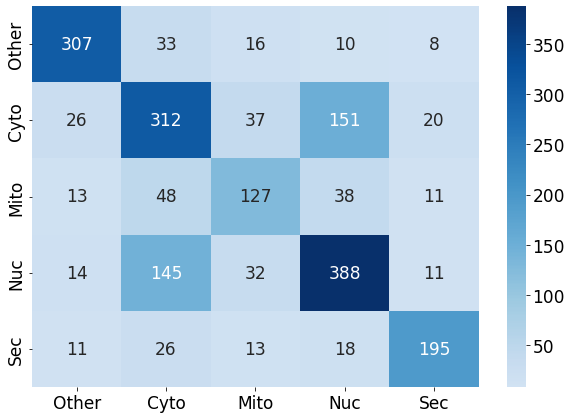

In [81]:
# plot confusion mtx

mtx1 = [[307,  33,  16,  10,   8],
 [ 26, 312,  37, 151,  20],
 [ 13,  48, 127,  38,  11],
 [ 14, 145,  32, 388,  11],
 [ 11,  26,  13,  18, 195]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((312-8)/2), fmt="d", cmap="Blues")

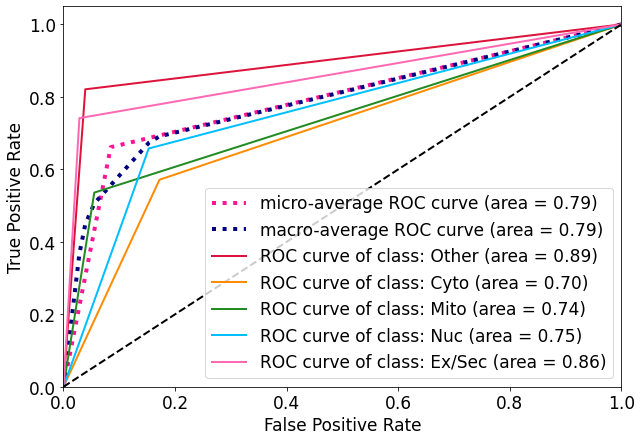

In [82]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Other", "Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[0, 1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()

### MLP

#### HPO

In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
parameters = {'max_iter':[300, 400], 
              'alpha':[1.e-1, 1.e-3, 1.e-5, 1.e-6, 1],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'learning_rate': ['constant', 'adaptive'], 
              'learning_rate_init': [1.e-1, 1.e-3],
              'early_stopping': [True, False]
             }

clf = MLPClassifier(random_state=1)

# search = GridSearchCV(clf, parameters)
# search.fit(X_res, y_res)

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=parameters, factor=2, random_state=42
)

In [85]:
rsh.fit(X_res, y_res)

HalvingRandomSearchCV(estimator=MLPClassifier(random_state=1), factor=2,
                      param_distributions={'activation': ['tanh', 'relu'],
                                           'alpha': [0.1, 0.001, 1e-05, 1e-06,
                                                     1],
                                           'early_stopping': [True, False],
                                           'learning_rate': ['constant',
                                                             'adaptive'],
                                           'learning_rate_init': [0.1, 0.001],
                                           'max_iter': [300, 400],
                                           'solver': ['sgd', 'adam']},
                      random_state=42)

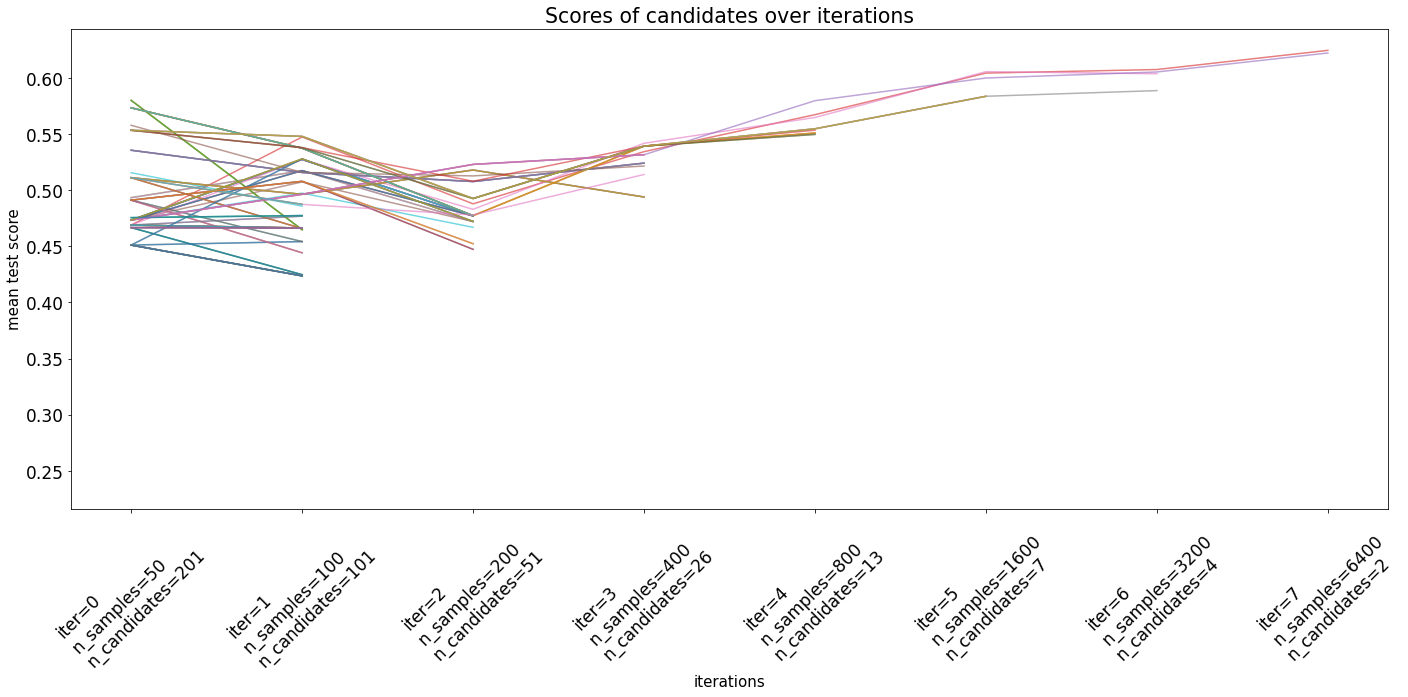

{'solver': 'adam',
 'max_iter': 300,
 'learning_rate_init': 0.001,
 'learning_rate': 'adaptive',
 'early_stopping': False,
 'alpha': 1,
 'activation': 'tanh'}

In [86]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

#### Model run with found parameters

In [87]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res)

print('=' * 80)
print("MLP")

i = 1

for train_index, test_index in kf.split(X_res):
    X_train, X_test = X_res[train_index], X_res[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    # clf = MLPClassifier(random_state=1, max_iter=300, alpha=1.05)
    clf = MLPClassifier(random_state=1, max_iter=300, alpha=1.05, solver='adam', learning_rate_init=0.001, learning_rate='adaptive', early_stopping=False, activation='tanh')
    name = 'MLP'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

 

MLP
Fold  1

accuracy:   0.651

classification report:
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       362
         1.0       0.57      0.50      0.53       533
         2.0       0.56      0.53      0.55       231
         3.0       0.60      0.71      0.65       604
         4.0       0.80      0.67      0.73       281

    accuracy                           0.65      2011
   macro avg       0.67      0.65      0.66      2011
weighted avg       0.65      0.65      0.65      2011

confusion matrix:
[[308  17  12  13  12]
 [ 21 264  33 199  16]
 [ 18  40 122  44   7]
 [ 18 116  31 427  12]
 [ 16  30  18  28 189]]

AUC metric:
0.8889459448055833

Matthews correlation coefficient:
0.5486024990331341
Fold  2

accuracy:   0.631

classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       348
         1.0       0.52      0.51      0.52       539
         2.0       0.5

<AxesSubplot:>

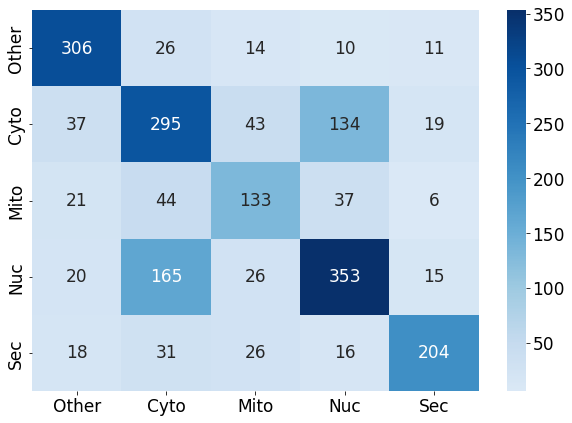

In [88]:
# plot confusion mtx

mtx1 = [[306,  26,  14,  10,  11],
 [ 37, 295,  43, 134,  19],
 [ 21,  44, 133,  37,   6],
 [ 20, 165,  26, 353,  15],
 [ 18,  31,  26,  16, 204]]
df_cm = pd.DataFrame(mtx1, index = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((306-6)/2), fmt="d", cmap="Blues")

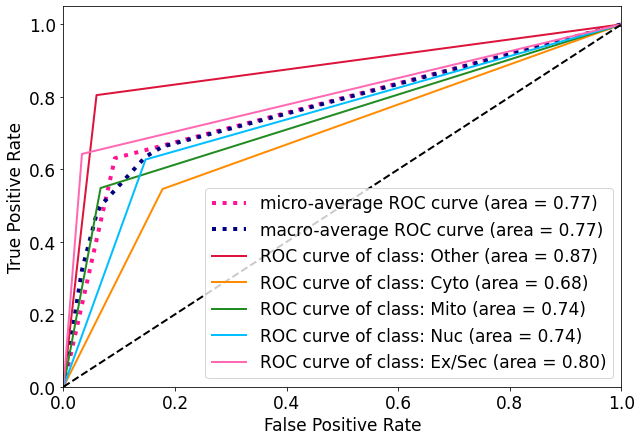

In [89]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Other", "Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[0, 1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()

## Approach 2: Train a Binary Classifier for "Other" Sequences, then Multiclass Classifier for the rest

1. Train a binary classifier for "other"
2. Train a multi-class classifier for the rest 
3. For inference, first run binary classifier, then if binary classifier predicts "0", run multiclass

### Binary Classifier

#### Data Processing

Here, the dataset created was edited to contain a binary label for prokaryotic or eukaryotic proteins.

In [91]:
# save data to read in later
features_df.to_csv("features_df.csv", index=False)

In [92]:
# get data 
bin_class_df = features_df
bin_class_df

,location,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,length,mol_weight,aromaticity,isoelectric_point,A_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,1.0,0.0,0.0,0.0,0.0,0.578619,0.510463,-1.559860,0.236532,0.565367,...,-0.568594,-0.470179,4.440589,0.431529,0.580748,0.985300,-0.038078,-0.772329,-0.543342,-0.965996
1,0.0,0.0,0.0,0.0,0.0,-0.387250,-0.418154,0.187560,0.946086,1.879947,...,-1.072172,-0.919214,0.371510,-0.776016,1.527549,-1.109914,0.113551,0.925377,2.578832,-0.913650
2,3.0,1.0,1.0,1.0,0.0,10.590828,10.243085,-1.801875,0.887539,0.109463,...,-0.309129,0.121878,0.938517,2.167240,-0.151968,1.946683,0.447277,-0.383683,-0.980697,-1.165531
3,2.0,0.0,0.0,0.0,1.0,0.252454,0.269597,0.468742,1.203336,0.004629,...,-0.653836,-0.120006,-0.571853,0.154194,-0.291526,-0.349117,-0.106482,-0.374205,-0.548472,0.454453
4,1.0,0.0,0.0,0.0,0.0,-0.841777,-0.830544,4.044291,0.731436,-1.010491,...,2.046532,-0.564385,-1.316419,-1.624720,-0.316737,1.002257,0.494491,-0.611316,1.171003,3.463211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,3.0,0.0,1.0,0.0,0.0,-0.040042,-0.041365,0.393720,0.795088,-0.530036,...,0.451846,1.401374,0.537460,0.285658,-0.390880,1.656116,0.297116,0.180368,-0.381684,-0.005291
10048,3.0,0.0,1.0,0.0,0.0,0.725919,0.759557,-1.022535,1.193091,-1.791783,...,-0.758799,9.619612,0.214307,2.516102,-1.232303,1.035550,-0.536297,-2.005034,-0.705754,-0.266443
10049,3.0,0.0,0.0,0.0,0.0,-0.109484,-0.065327,-0.113233,-1.079667,-0.798585,...,-0.075240,-0.012353,-0.176771,-0.237373,-0.113818,-0.281783,-0.763725,-0.746874,0.502530,-0.520215
10050,1.0,0.0,0.0,0.0,0.0,-0.210490,-0.208725,-0.383637,-0.451459,-0.854090,...,-0.073243,0.915188,-0.477036,-0.148741,-0.420224,-0.714618,0.506509,0.521721,-0.234415,0.050450


In [93]:
# alter bin_class_df 
bin_class_df.loc[bin_class_df['location'] > 0, 'location'] = 1
bin_class_df

,location,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,length,mol_weight,aromaticity,isoelectric_point,A_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,1.0,0.0,0.0,0.0,0.0,0.578619,0.510463,-1.559860,0.236532,0.565367,...,-0.568594,-0.470179,4.440589,0.431529,0.580748,0.985300,-0.038078,-0.772329,-0.543342,-0.965996
1,0.0,0.0,0.0,0.0,0.0,-0.387250,-0.418154,0.187560,0.946086,1.879947,...,-1.072172,-0.919214,0.371510,-0.776016,1.527549,-1.109914,0.113551,0.925377,2.578832,-0.913650
2,1.0,1.0,1.0,1.0,0.0,10.590828,10.243085,-1.801875,0.887539,0.109463,...,-0.309129,0.121878,0.938517,2.167240,-0.151968,1.946683,0.447277,-0.383683,-0.980697,-1.165531
3,1.0,0.0,0.0,0.0,1.0,0.252454,0.269597,0.468742,1.203336,0.004629,...,-0.653836,-0.120006,-0.571853,0.154194,-0.291526,-0.349117,-0.106482,-0.374205,-0.548472,0.454453
4,1.0,0.0,0.0,0.0,0.0,-0.841777,-0.830544,4.044291,0.731436,-1.010491,...,2.046532,-0.564385,-1.316419,-1.624720,-0.316737,1.002257,0.494491,-0.611316,1.171003,3.463211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,1.0,0.0,1.0,0.0,0.0,-0.040042,-0.041365,0.393720,0.795088,-0.530036,...,0.451846,1.401374,0.537460,0.285658,-0.390880,1.656116,0.297116,0.180368,-0.381684,-0.005291
10048,1.0,0.0,1.0,0.0,0.0,0.725919,0.759557,-1.022535,1.193091,-1.791783,...,-0.758799,9.619612,0.214307,2.516102,-1.232303,1.035550,-0.536297,-2.005034,-0.705754,-0.266443
10049,1.0,0.0,0.0,0.0,0.0,-0.109484,-0.065327,-0.113233,-1.079667,-0.798585,...,-0.075240,-0.012353,-0.176771,-0.237373,-0.113818,-0.281783,-0.763725,-0.746874,0.502530,-0.520215
10050,1.0,0.0,0.0,0.0,0.0,-0.210490,-0.208725,-0.383637,-0.451459,-0.854090,...,-0.073243,0.915188,-0.477036,-0.148741,-0.420224,-0.714618,0.506509,0.521721,-0.234415,0.050450


In [94]:
bin_class_df.location.value_counts()

1.0    8253
0.0    1799
Name: location, dtype: int64

In [96]:
X_bin = np.delete(bin_class_df_np, 0, axis=1)
y_bin = bin_class_df_np[:,0]

X_res_bin = X_bin
y_res_bin = y_bin

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_res_bin, y_res_bin, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8041, 48), (2011, 48), (8041,), (2011,))

#### Train a model

As the binary model is of less importance than the multi-class model, an initial model was trained and validated using 5-fold cross validation with the highest performing model from Approach 1, SVM. This would provide a preliminary result, which could be further refined if the 4-class model performs better than the 5-class model. 

In [101]:
def algorithm_binary(clf, name):
    # fit the data to the model
    clf.fit(X_train, y_train)
    
    # need to persist the model for later
    modelname = name
    
    # make predictions using the test input data
    pred = clf.predict(X_test)
    
    # compute some metrics to assess the accuracy of the predictions using this algorithm
    score = metrics.accuracy_score(y_test, pred)
    class_report = metrics.classification_report(y_test, pred)
    
    # A breakdown of predictions into a table showing correct predictions (the diagonal) 
    # and the types of incorrect predictions made (what classes incorrect predictions were assigned).
    confusionmtx = metrics.confusion_matrix(y_test, pred)
    
    auc_score = roc_auc_score(y_test, pred) 
    
    matthews_coeff = matthews_corrcoef(y_test, pred)
    
    # return the metrics 
    return score, class_report, confusionmtx, auc_score, matthews_coeff, pred

##### SVM

In [102]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res)

print('=' * 80)
print("SVM")

i = 1
for train_index, test_index in kf.split(X_res):
    X_train, X_test = X_res[train_index], X_res[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res[train_index], y_res[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = SVC(probability=True, random_state=42, kernel="rbf", gamma="scale", decision_function_shape="ovo", C=1.5)
    name = 'SVM'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm_binary(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

SVM
Fold  1

accuracy:   0.949

classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85       362
         1.0       0.96      0.98      0.97      1649

    accuracy                           0.95      2011
   macro avg       0.93      0.89      0.91      2011
weighted avg       0.95      0.95      0.95      2011

confusion matrix:
[[ 289   73]
 [  29 1620]]

AUC metric:
0.8903780627133807

Matthews correlation coefficient:
0.8221252259317728
Fold  2

accuracy:   0.945

classification report:
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.83       348
         1.0       0.96      0.98      0.97      1663

    accuracy                           0.95      2011
   macro avg       0.92      0.89      0.90      2011
weighted avg       0.94      0.95      0.94      2011

confusion matrix:
[[ 277   71]
 [  39 1624]]

AUC metric:
0.8862627089942701

Matthews correlation coefficien

<AxesSubplot:>

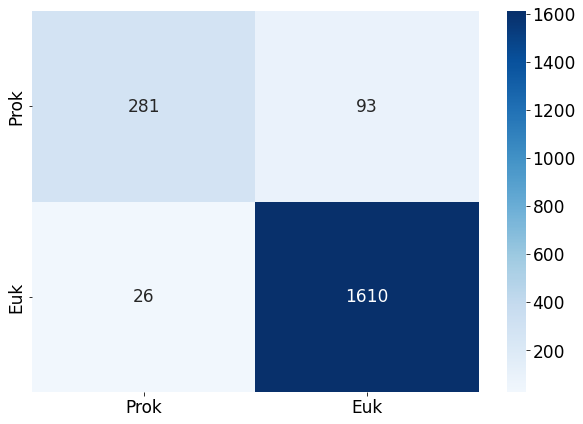

In [104]:
# plot confusion mtx

mtx1 = [[ 281,   93],
 [  26, 1610]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Prok", "Euk"]],
                  columns = [i for i in ["Prok", "Euk"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((1610-26)/2), fmt="d", cmap="Blues")

In [128]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res_bin)

print('=' * 80)
print("Random Forest")

i = 1

for train_index, test_index in kf.split(X_res_bin):
    X_train, X_test = X_res_bin[train_index], X_res_bin[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res_bin[train_index], y_res_bin[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = RandomForestClassifier(bootstrap= False, criterion='gini', max_depth= None, max_features= 3, min_samples_split= 3, n_estimators= 150, random_state=42)
    name = 'Random Forest'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm_binary(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

Random Forest
Fold  1

accuracy:   0.971

classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1648
         1.0       0.97      0.97      0.97      1653

    accuracy                           0.97      3301
   macro avg       0.97      0.97      0.97      3301
weighted avg       0.97      0.97      0.97      3301

confusion matrix:
[[1604   44]
 [  51 1602]]

AUC metric:
0.9712239881592163

Matthews correlation coefficient:
0.9424503980557792
Fold  2

accuracy:   0.969

classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1649
         1.0       0.97      0.97      0.97      1652

    accuracy                           0.97      3301
   macro avg       0.97      0.97      0.97      3301
weighted avg       0.97      0.97      0.97      3301

confusion matrix:
[[1603   46]
 [  57 1595]]

AUC metric:
0.9688003368392614

Matthews correlation 

<AxesSubplot:>

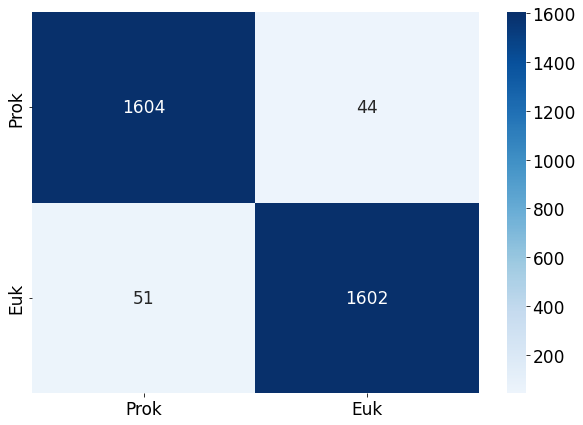

In [185]:
# plot confusion mtx

mtx1 = [[1604,   44],
 [  51, 1602]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Prok", "Euk"]],
                  columns = [i for i in ["Prok", "Euk"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((1604-44)/2), fmt="d", cmap="Blues")

<Figure size 720x504 with 0 Axes>

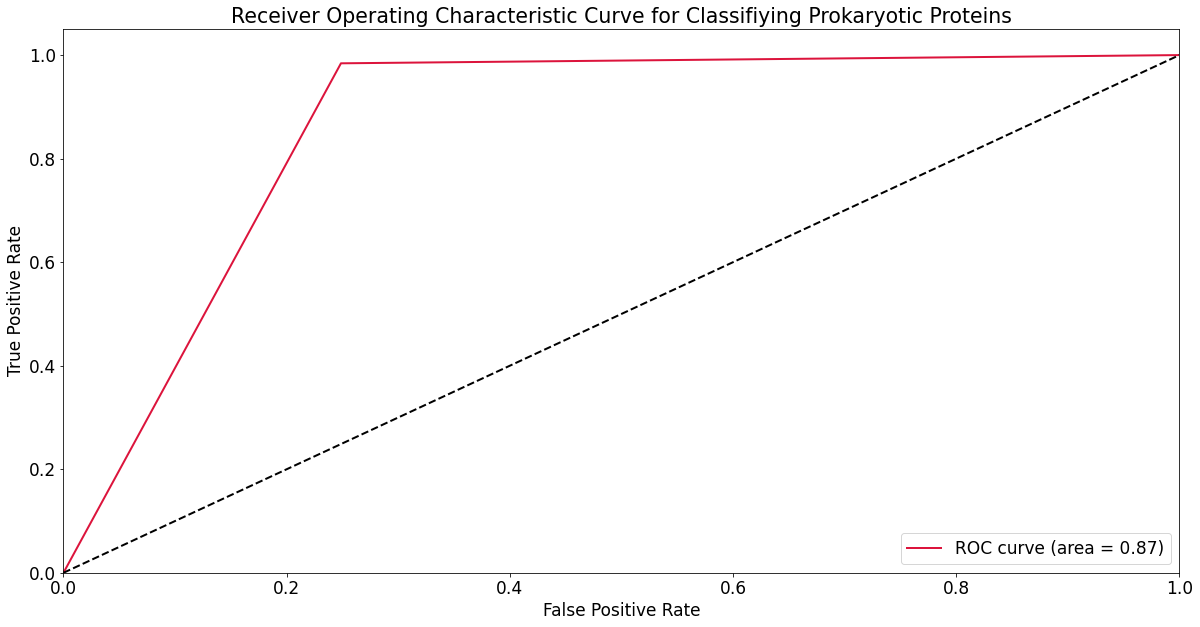

In [105]:
y_test_bin = label_binarize(y_test, classes=[0, 1])
n_classes = y_test_bin.shape[1]
classes = ["Other"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[0, 1])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

plt.figure(figsize = (10,7))

plt.figure()

lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="crimson",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve for Classifiying Prokaryotic Proteins")
plt.legend(loc="lower right")
plt.show()

### Multi-Class Classifier

#### Data Processing

Remove the prokaryotic class.

In [106]:
features_df = pd.read_csv("features_df.csv")

In [107]:
multi_class_df = features_df
multi_class_df

,location,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,length,mol_weight,aromaticity,isoelectric_point,A_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,1.0,0.0,0.0,0.0,0.0,0.578619,0.510463,-1.559860,0.236532,0.565367,...,-0.568594,-0.470179,4.440589,0.431529,0.580748,0.985300,-0.038078,-0.772329,-0.543342,-0.965996
1,0.0,0.0,0.0,0.0,0.0,-0.387250,-0.418154,0.187560,0.946086,1.879947,...,-1.072172,-0.919214,0.371510,-0.776016,1.527549,-1.109914,0.113551,0.925377,2.578832,-0.913650
2,3.0,1.0,1.0,1.0,0.0,10.590828,10.243085,-1.801875,0.887539,0.109463,...,-0.309129,0.121878,0.938517,2.167240,-0.151968,1.946683,0.447277,-0.383683,-0.980697,-1.165531
3,2.0,0.0,0.0,0.0,1.0,0.252454,0.269597,0.468742,1.203336,0.004629,...,-0.653836,-0.120006,-0.571853,0.154194,-0.291526,-0.349117,-0.106482,-0.374205,-0.548472,0.454453
4,1.0,0.0,0.0,0.0,0.0,-0.841777,-0.830544,4.044291,0.731436,-1.010491,...,2.046532,-0.564385,-1.316419,-1.624720,-0.316737,1.002257,0.494491,-0.611316,1.171003,3.463211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,3.0,0.0,1.0,0.0,0.0,-0.040042,-0.041365,0.393720,0.795088,-0.530036,...,0.451846,1.401374,0.537460,0.285658,-0.390880,1.656116,0.297116,0.180368,-0.381684,-0.005291
10048,3.0,0.0,1.0,0.0,0.0,0.725919,0.759557,-1.022535,1.193091,-1.791783,...,-0.758799,9.619612,0.214307,2.516102,-1.232303,1.035550,-0.536297,-2.005034,-0.705754,-0.266443
10049,3.0,0.0,0.0,0.0,0.0,-0.109484,-0.065327,-0.113233,-1.079667,-0.798585,...,-0.075240,-0.012353,-0.176771,-0.237373,-0.113818,-0.281783,-0.763725,-0.746874,0.502530,-0.520215
10050,1.0,0.0,0.0,0.0,0.0,-0.210490,-0.208725,-0.383637,-0.451459,-0.854090,...,-0.073243,0.915188,-0.477036,-0.148741,-0.420224,-0.714618,0.506509,0.521721,-0.234415,0.050450


In [108]:
# drop where loc = 0 
multi_class_df.drop(multi_class_df[multi_class_df.location == 0].index, inplace=True)
multi_class_df

,location,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,length,mol_weight,aromaticity,isoelectric_point,A_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,1.0,0.0,0.0,0.0,0.0,0.578619,0.510463,-1.559860,0.236532,0.565367,...,-0.568594,-0.470179,4.440589,0.431529,0.580748,0.985300,-0.038078,-0.772329,-0.543342,-0.965996
2,3.0,1.0,1.0,1.0,0.0,10.590828,10.243085,-1.801875,0.887539,0.109463,...,-0.309129,0.121878,0.938517,2.167240,-0.151968,1.946683,0.447277,-0.383683,-0.980697,-1.165531
3,2.0,0.0,0.0,0.0,1.0,0.252454,0.269597,0.468742,1.203336,0.004629,...,-0.653836,-0.120006,-0.571853,0.154194,-0.291526,-0.349117,-0.106482,-0.374205,-0.548472,0.454453
4,1.0,0.0,0.0,0.0,0.0,-0.841777,-0.830544,4.044291,0.731436,-1.010491,...,2.046532,-0.564385,-1.316419,-1.624720,-0.316737,1.002257,0.494491,-0.611316,1.171003,3.463211
7,1.0,0.0,1.0,0.0,0.0,0.690146,0.655778,-1.149530,-0.661503,1.606447,...,-0.738480,-1.424062,0.255664,0.227459,0.502915,-0.522647,-0.200824,0.674720,-0.004862,-1.017654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047,3.0,0.0,1.0,0.0,0.0,-0.040042,-0.041365,0.393720,0.795088,-0.530036,...,0.451846,1.401374,0.537460,0.285658,-0.390880,1.656116,0.297116,0.180368,-0.381684,-0.005291
10048,3.0,0.0,1.0,0.0,0.0,0.725919,0.759557,-1.022535,1.193091,-1.791783,...,-0.758799,9.619612,0.214307,2.516102,-1.232303,1.035550,-0.536297,-2.005034,-0.705754,-0.266443
10049,3.0,0.0,0.0,0.0,0.0,-0.109484,-0.065327,-0.113233,-1.079667,-0.798585,...,-0.075240,-0.012353,-0.176771,-0.237373,-0.113818,-0.281783,-0.763725,-0.746874,0.502530,-0.520215
10050,1.0,0.0,0.0,0.0,0.0,-0.210490,-0.208725,-0.383637,-0.451459,-0.854090,...,-0.073243,0.915188,-0.477036,-0.148741,-0.420224,-0.714618,0.506509,0.521721,-0.234415,0.050450


In [110]:
X_mul = np.delete(multi_class_df_np, 0, axis=1)
y_mul = multi_class_df_np[:,0]

X_res_mul = X_mul
y_res_mul = y_mul

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_res_mul, y_res_mul, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6602, 48), (1651, 48), (6602,), (1651,))

#### Train a Model

##### Random Forest

In [112]:
clf = RandomForestClassifier(random_state=42)

clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [113]:
param_dist = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, None],
    "max_features": randint(1, 6),
    "min_samples_split": randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=42
)
rsh.fit(X_res_mul, y_res_mul)

HalvingRandomSearchCV(estimator=RandomForestClassifier(random_state=42),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9122509fa0>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9122521730>,
                                           'n_estimators': [50, 100, 150]},
                      random_state=42)

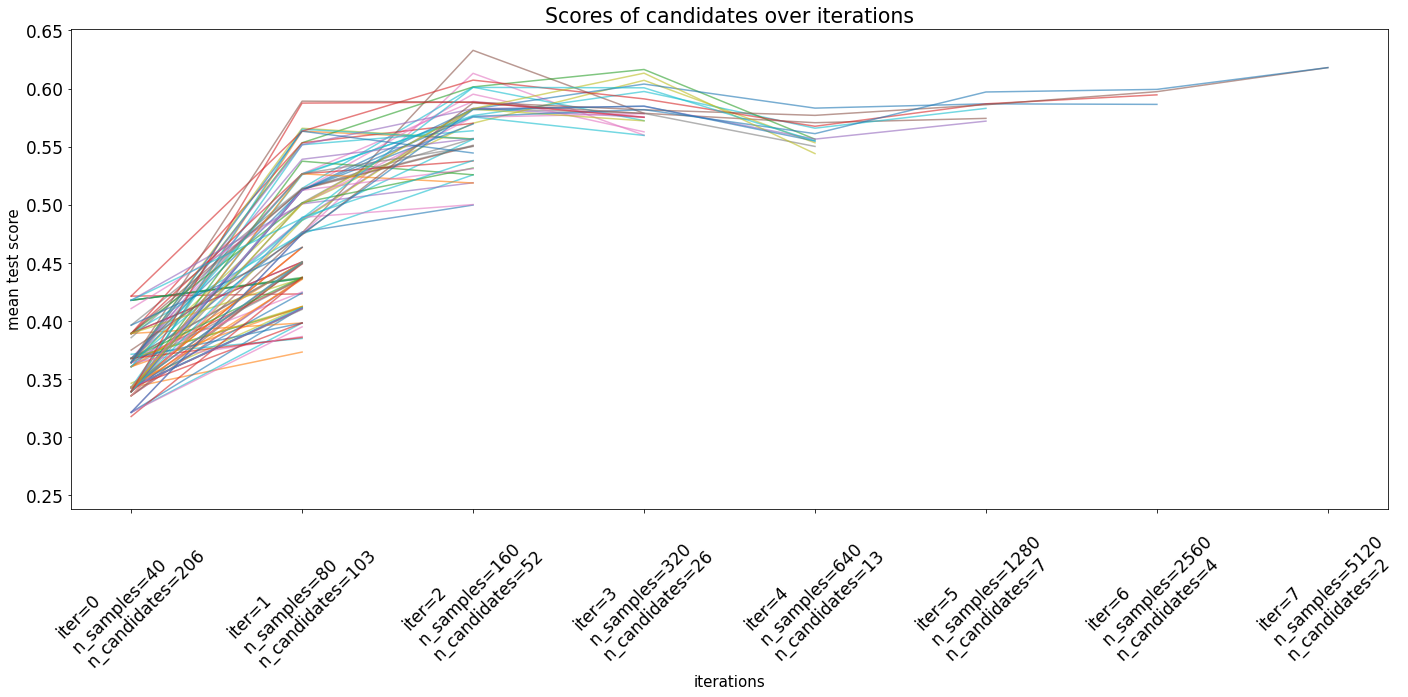

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'min_samples_split': 5,
 'n_estimators': 100}

In [114]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

In [115]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res_mul)

print('=' * 80)
print("Random Forest")

i = 1

for train_index, test_index in kf.split(X_res_mul):
    X_train, X_test = X_res_mul[train_index], X_res_mul[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res_mul[train_index], y_res_mul[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = RandomForestClassifier(bootstrap= False, criterion='gini', max_depth= None, max_features= 3, min_samples_split= 5, n_estimators= 100, random_state=42)
    name = 'Random Forest'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

Random Forest
Fold  1

accuracy:   0.626

classification report:
              precision    recall  f1-score   support

         1.0       0.55      0.58      0.56       530
         2.0       0.58      0.47      0.52       229
         3.0       0.64      0.70      0.67       627
         4.0       0.80      0.68      0.74       265

    accuracy                           0.63      1651
   macro avg       0.64      0.61      0.62      1651
weighted avg       0.63      0.63      0.63      1651

confusion matrix:
[[305  42 164  19]
 [ 58 108  49  14]
 [146  29 441  11]
 [ 46   8  31 180]]

AUC metric:
0.8486098761750172

Matthews correlation coefficient:
0.4648308419494624
Fold  2

accuracy:   0.619

classification report:
              precision    recall  f1-score   support

         1.0       0.51      0.56      0.53       503
         2.0       0.62      0.44      0.51       237
         3.0       0.64      0.66      0.65       627
         4.0       0.79      0.78      0.79       2

<AxesSubplot:>

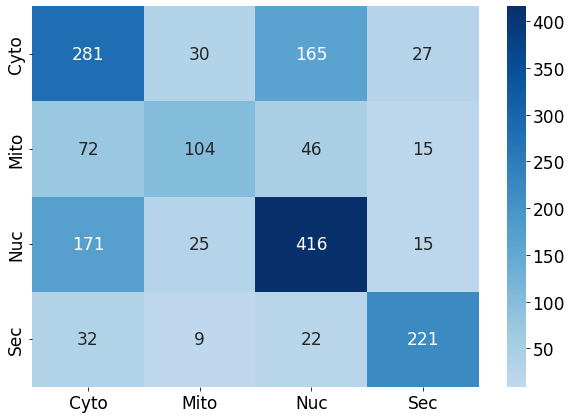

In [117]:
# plot confusion mtx

mtx1 = [[281,  30, 165,  27],
 [ 72, 104,  46,  15],
 [171,  25, 416,  15],
 [ 32,   9,  22, 221]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((281-9)/2), fmt="d", cmap="Blues")

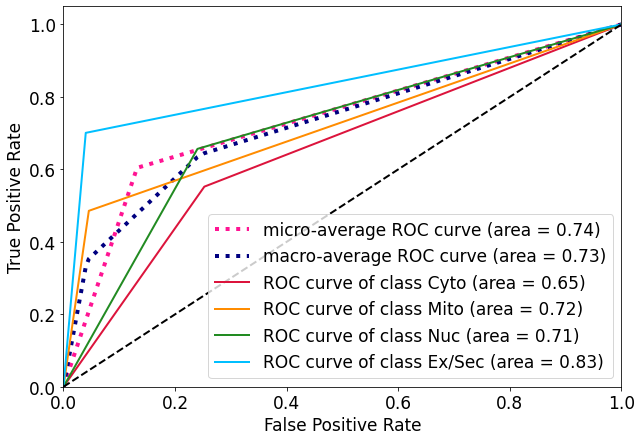

In [118]:
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()

##### kNN

In [119]:
clf = KNeighborsClassifier()
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [120]:
param_dist = {
    "n_neighbors": [5, 10, 15, 20, 25],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2]
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=42
)
rsh.fit(X_res_mul, y_res_mul)

HalvingRandomSearchCV(estimator=KNeighborsClassifier(), factor=2,
                      param_distributions={'algorithm': ['auto', 'ball_tree',
                                                         'kd_tree', 'brute'],
                                           'n_neighbors': [5, 10, 15, 20, 25],
                                           'p': [1, 2],
                                           'weights': ['uniform', 'distance']},
                      random_state=42)

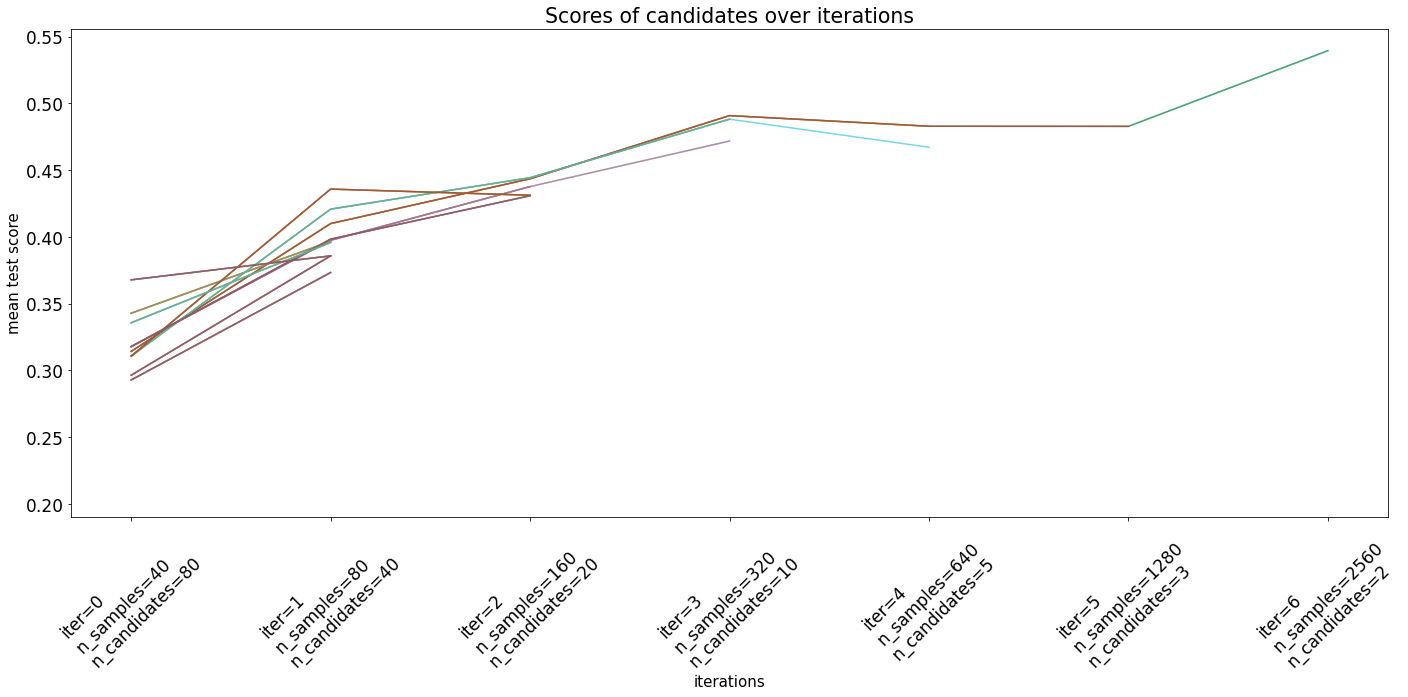

{'weights': 'distance', 'p': 1, 'n_neighbors': 10, 'algorithm': 'brute'}

In [121]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

In [122]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res_mul)

print('=' * 80)
print("kNN")

i = 1
for train_index, test_index in kf.split(X_res_mul):
    X_train, X_test = X_res_mul[train_index], X_res_mul[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res_mul[train_index], y_res_mul[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = KNeighborsClassifier(n_neighbors=10, weights='distance', p=1, algorithm='brute')
    name = 'kNN'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

kNN
Fold  1

accuracy:   0.579

classification report:
              precision    recall  f1-score   support

         1.0       0.49      0.59      0.53       530
         2.0       0.50      0.56      0.53       229
         3.0       0.63      0.63      0.63       627
         4.0       0.92      0.46      0.62       265

    accuracy                           0.58      1651
   macro avg       0.63      0.56      0.58      1651
weighted avg       0.61      0.58      0.58      1651

confusion matrix:
[[311  56 157   6]
 [ 61 128  35   5]
 [196  37 394   0]
 [ 67  34  41 123]]

AUC metric:
0.8152709942179086

Matthews correlation coefficient:
0.399914432046745
Fold  2

accuracy:   0.582

classification report:
              precision    recall  f1-score   support

         1.0       0.49      0.60      0.54       503
         2.0       0.51      0.50      0.51       237
         3.0       0.61      0.61      0.61       627
         4.0       0.90      0.55      0.68       284

    acc

<AxesSubplot:>

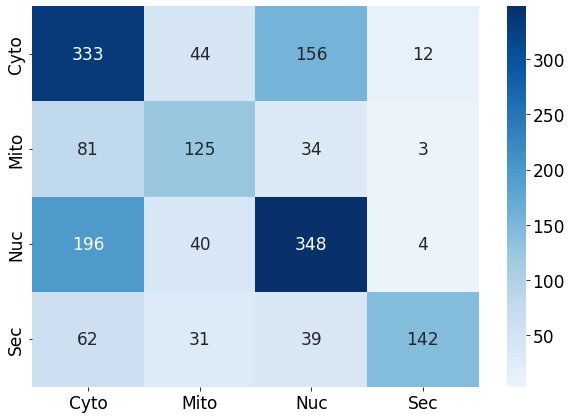

In [123]:
# plot confusion mtx

mtx1 = [[333,  44, 156,  12],
 [ 81, 125,  34,   3],
 [196,  40, 348,   4],
 [ 62,  31,  39, 142]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((333-3)/2), fmt="d", cmap="Blues")

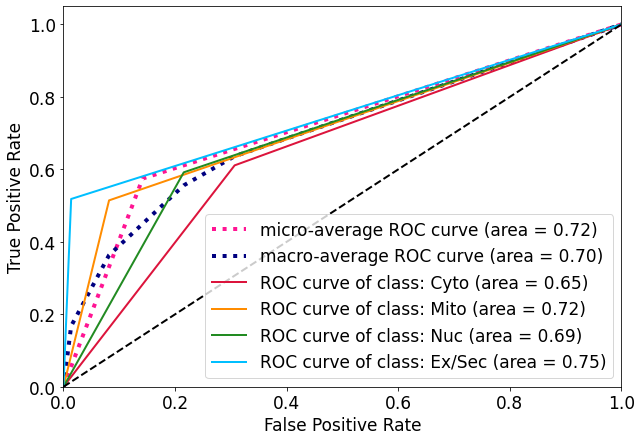

In [124]:
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()

##### SVM

In [125]:
clf = SVC(random_state=42)
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [126]:
param_dist = {
    "kernel": ["poly", "rbf", "sigmoid"],
    "C": [1.0, 1.5, 2.0],
    "gamma": ["scale", "auto"], 
    "decision_function_shape": ["ovo", "ovr"]
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=42
)
rsh.fit(X_res_mul, y_res_mul)

HalvingRandomSearchCV(estimator=SVC(random_state=42), factor=2,
                      param_distributions={'C': [1.0, 1.5, 2.0],
                                           'decision_function_shape': ['ovo',
                                                                       'ovr'],
                                           'gamma': ['scale', 'auto'],
                                           'kernel': ['poly', 'rbf',
                                                      'sigmoid']},
                      random_state=42)

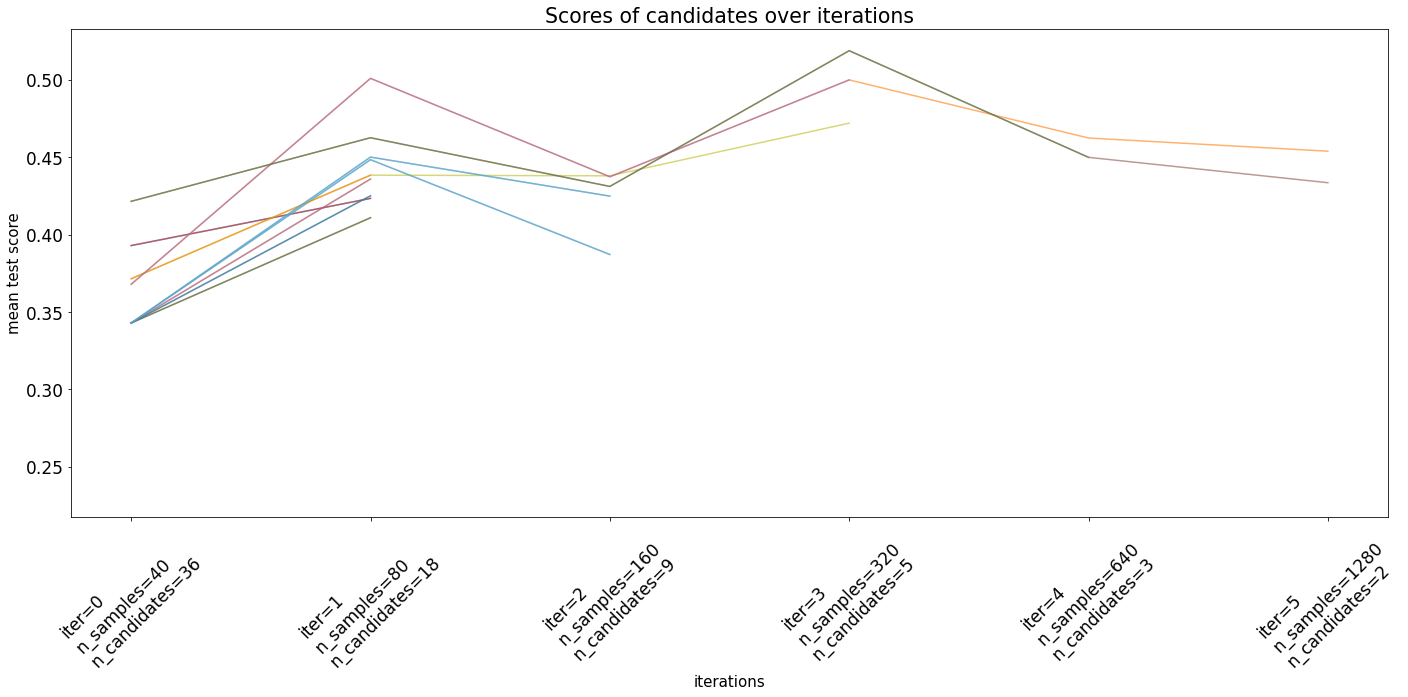

{'kernel': 'sigmoid',
 'gamma': 'scale',
 'decision_function_shape': 'ovo',
 'C': 1.5}

In [127]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

In [129]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res_mul)

print('=' * 80)
print("SVM")

i = 1
for train_index, test_index in kf.split(X_res_mul):
    X_train, X_test = X_res_mul[train_index], X_res_mul[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res_mul[train_index], y_res_mul[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = SVC(probability=True, random_state=42, kernel="rbf", gamma="scale", decision_function_shape="ovo", C=1.5)
    name = 'SVM'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

SVM
Fold  1

accuracy:   0.649

classification report:
              precision    recall  f1-score   support

         1.0       0.55      0.63      0.59       530
         2.0       0.59      0.60      0.59       229
         3.0       0.70      0.65      0.68       627
         4.0       0.85      0.72      0.78       265

    accuracy                           0.65      1651
   macro avg       0.67      0.65      0.66      1651
weighted avg       0.66      0.65      0.65      1651

confusion matrix:
[[336  49 132  13]
 [ 55 137  25  12]
 [176  35 408   8]
 [ 47  13  14 191]]

AUC metric:
0.8596618082957859

Matthews correlation coefficient:
0.5047175092698516
Fold  2

accuracy:   0.635

classification report:
              precision    recall  f1-score   support

         1.0       0.53      0.59      0.56       503
         2.0       0.59      0.51      0.55       237
         3.0       0.67      0.63      0.65       627
         4.0       0.81      0.81      0.81       284

    ac

<AxesSubplot:>

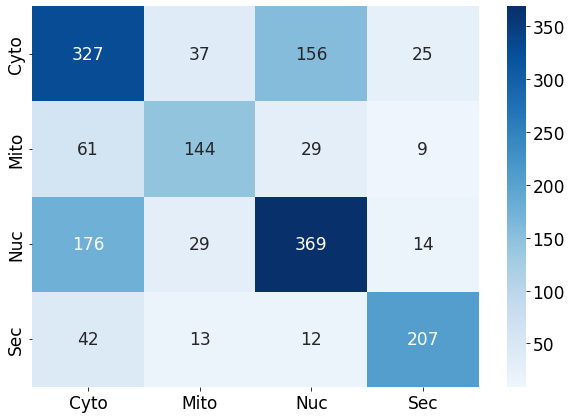

In [130]:
# plot confusion mtx

mtx1 = [[327,  37, 156,  25],
 [ 61, 144,  29,   9],
 [176,  29, 369,  14],
 [ 42,  13,  12, 207]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((369-9)/2), fmt="d", cmap="Blues")

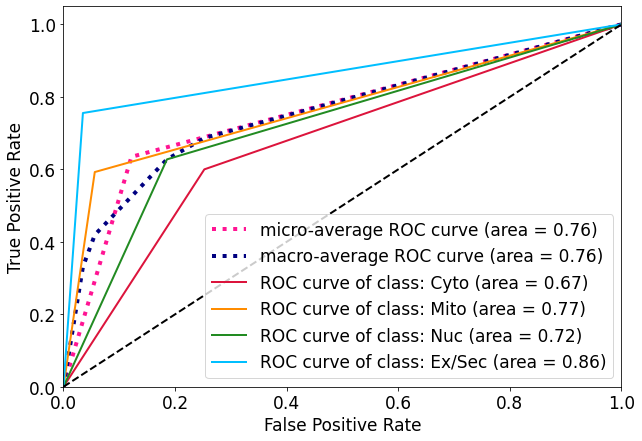

In [131]:
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()

##### MLP

In [132]:
import warnings
warnings.filterwarnings('ignore')

parameters = {'max_iter':[300, 400], 
              'alpha':[1.e-1, 1.e-3, 1.e-5, 1.e-6, 1],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'learning_rate': ['constant', 'adaptive'], 
              'learning_rate_init': [1.e-1, 1.e-3],
              'early_stopping': [True, False]
             }

clf = MLPClassifier(random_state=1)

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=parameters, factor=2, random_state=42
)

In [133]:
rsh.fit(X_res_mul, y_res_mul)

HalvingRandomSearchCV(estimator=MLPClassifier(random_state=1), factor=2,
                      param_distributions={'activation': ['tanh', 'relu'],
                                           'alpha': [0.1, 0.001, 1e-05, 1e-06,
                                                     1],
                                           'early_stopping': [True, False],
                                           'learning_rate': ['constant',
                                                             'adaptive'],
                                           'learning_rate_init': [0.1, 0.001],
                                           'max_iter': [300, 400],
                                           'solver': ['sgd', 'adam']},
                      random_state=42)

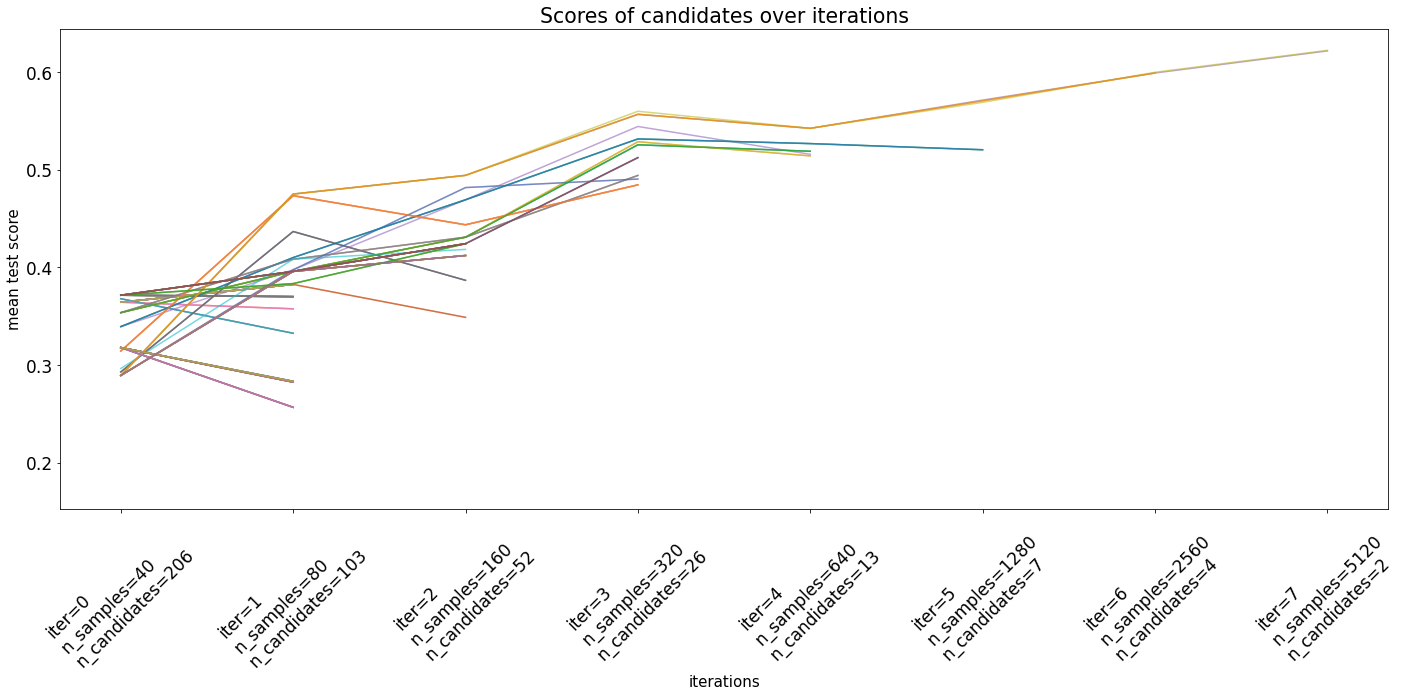

{'solver': 'sgd',
 'max_iter': 300,
 'learning_rate_init': 0.001,
 'learning_rate': 'constant',
 'early_stopping': False,
 'alpha': 0.1,
 'activation': 'relu'}

In [134]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]
# plt.rcParams["figure.figsize"] = (20,10)
ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

best_params = rsh.best_params_ 
best_params

In [135]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
kf.get_n_splits(X_res)

print('=' * 80)
print("MLP")

i = 1

for train_index, test_index in kf.split(X_res_mul):
    X_train, X_test = X_res_mul[train_index], X_res_mul[test_index]
    # print(X_train.shape, X_test.shape)
    y_train, y_test = y_res_mul[train_index], y_res_mul[test_index]
    # print(y_train.shape, y_test.shape)
    
    print('=' * 80)
    print("Fold ", i)
    
    clf = MLPClassifier(random_state=1, max_iter=300, alpha=0.1, solver="sgd", learning_rate_init=0.001, learning_rate='constant', activation='relu')
    name = 'MLP'

    score, class_report, confusionmtx, auc_score, matthews_coeff, pred = algorithm(clf, name)

    print("\naccuracy:   %0.3f" % score)
    print("\nclassification report:")
    print (class_report)
    print("confusion matrix:")
    print (confusionmtx)
    print ("\nAUC metric:")
    print (auc_score)
    print ("\nMatthews correlation coefficient:")
    print (matthews_coeff)
    
    i = i + 1

 

MLP
Fold  1

accuracy:   0.632

classification report:
              precision    recall  f1-score   support

         1.0       0.54      0.60      0.57       530
         2.0       0.58      0.56      0.57       229
         3.0       0.67      0.66      0.67       627
         4.0       0.82      0.69      0.75       265

    accuracy                           0.63      1651
   macro avg       0.65      0.63      0.64      1651
weighted avg       0.64      0.63      0.63      1651

confusion matrix:
[[316  49 146  19]
 [ 52 129  35  13]
 [171  31 416   9]
 [ 48  15  20 182]]

AUC metric:
0.8506790370117996

Matthews correlation coefficient:
0.4771380241640142
Fold  2

accuracy:   0.630

classification report:
              precision    recall  f1-score   support

         1.0       0.54      0.55      0.55       503
         2.0       0.54      0.51      0.52       237
         3.0       0.66      0.67      0.67       627
         4.0       0.80      0.77      0.79       284

    ac

<AxesSubplot:>

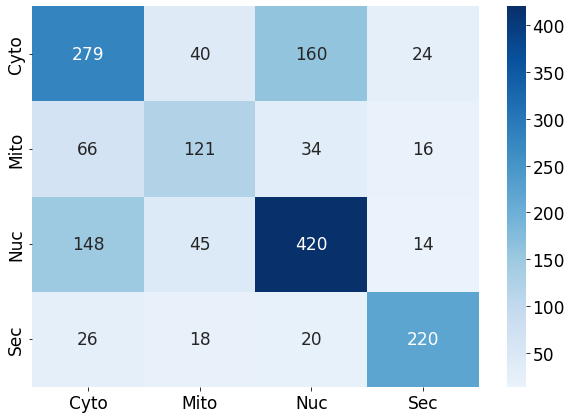

In [136]:
# plot confusion mtx

mtx1 = [[279,  40, 160,  24],
 [ 66, 121,  34,  16],
 [148,  45, 420,  14],
 [ 26,  18,  20, 220]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((420-16)/2), fmt="d", cmap="Blues")

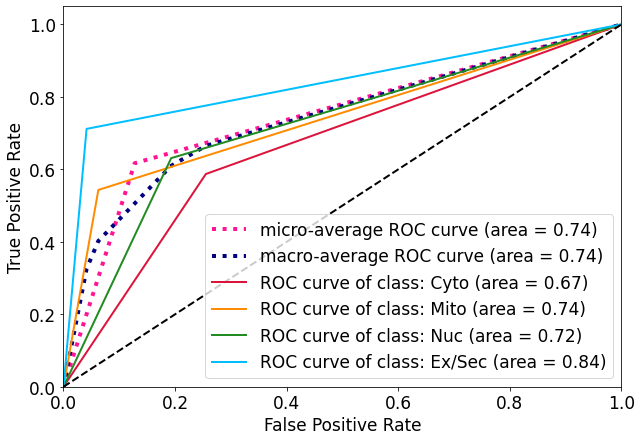

In [137]:
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred, classes=[1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()

## Evaluate on Test data 

In this section, we evaluate the best model, the 5-class SVM model, on the test set.

#### Standardise the test data

Process the test data in the same way we did the training data.

In [195]:
test_data_X.shape, test_data_y.shape

((1117, 48), (1117,))

In [196]:
# get X_train and y_train into a DF
cols = ['length',
 'mol_weight',
 'aromaticity',
 'isoelectric_point',
 'nuc_seq_1',
 'nuc_seq_2',
 'nuc_seq_3',
 'sec_seq',
 'A_local',
 'C_local',
 'D_local',
 'E_local',
 'F_local',
 'G_local',
 'H_local',
 'I_local',
 'K_local',
 'L_local',
 'M_local',
 'N_local',
 'P_local',
 'Q_local',
 'R_local',
 'S_local',
 'T_local',
 'V_local',
 'W_local',
 'Y_local',
 'A_global',
 'C_global',
 'D_global',
 'E_global',
 'F_global',
 'G_global',
 'H_global',
 'I_global',
 'K_global',
 'L_global',
 'M_global',
 'N_global',
 'P_global',
 'Q_global',
 'R_global',
 'S_global',
 'T_global',
 'V_global',
 'W_global',
 'Y_global']

testing_df = pd.DataFrame(test_data_X, columns = cols)
testing_df_y = pd.DataFrame(test_data_y, columns = ['location'])
testing_df_y = pd.concat([testing_df,testing_df_y], axis=1)
testing_df_y

,length,mol_weight,aromaticity,isoelectric_point,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,A_local,C_local,...,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global,location
0,182.0,21372.8775,0.109890,10.840439,0.0,1.0,0.0,0.0,0.021978,0.005495,...,0.043956,0.087912,0.043956,0.109890,0.082418,0.000000,0.082418,0.005495,0.049451,2.0
1,119.0,11268.2155,0.033613,11.068786,0.0,0.0,0.0,0.0,0.218487,0.000000,...,0.008403,0.016807,0.008403,0.025210,0.142857,0.058824,0.134454,0.000000,0.008403,2.0
2,2322.0,265475.8208,0.081826,7.907644,0.0,0.0,1.0,0.0,0.062446,0.012489,...,0.055125,0.029285,0.041344,0.055986,0.079673,0.063307,0.067183,0.018519,0.021533,1.0
3,217.0,24779.9126,0.041475,8.815423,0.0,0.0,0.0,0.0,0.036866,0.023041,...,0.078341,0.073733,0.046083,0.064516,0.082949,0.082949,0.059908,0.004608,0.009217,3.0
4,22.0,2453.7195,0.181818,4.531341,0.0,0.0,0.0,0.0,0.045455,0.045455,...,0.045455,0.045455,0.045455,0.000000,0.090909,0.000000,0.090909,0.000000,0.181818,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,585.0,67568.8583,0.107692,6.766023,0.0,0.0,0.0,0.0,0.032479,0.011966,...,0.090598,0.041026,0.032479,0.034188,0.075214,0.058120,0.039316,0.010256,0.037607,2.0
1113,332.0,38680.4119,0.144578,9.086770,0.0,0.0,0.0,0.0,0.036145,0.009036,...,0.057229,0.033133,0.033133,0.033133,0.069277,0.048193,0.066265,0.003012,0.069277,0.0
1114,1311.0,143188.9004,0.075515,5.489646,0.0,1.0,0.0,0.0,0.086957,0.019832,...,0.030511,0.090770,0.045004,0.052632,0.093059,0.041953,0.055683,0.012204,0.024409,1.0
1115,419.0,47557.6806,0.042959,8.749214,0.0,0.0,0.0,0.0,0.062053,0.035800,...,0.042959,0.062053,0.059666,0.085919,0.095465,0.076372,0.040573,0.004773,0.019093,3.0


In [197]:
# select the cols we want to standardise 
standardised_features_df = testing_df_y
standardised_features_df = standardised_features_df.drop(columns=['location', 'nuc_seq_1', 'nuc_seq_2', 'nuc_seq_3', 'sec_seq'])
standardised_features_df

,length,mol_weight,aromaticity,isoelectric_point,A_local,C_local,D_local,E_local,F_local,G_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,182.0,21372.8775,0.109890,10.840439,0.021978,0.005495,0.016484,0.043956,0.054945,0.060440,...,0.016484,0.043956,0.087912,0.043956,0.109890,0.082418,0.000000,0.082418,0.005495,0.049451
1,119.0,11268.2155,0.033613,11.068786,0.218487,0.000000,0.000000,0.008403,0.025210,0.117647,...,0.042017,0.008403,0.016807,0.008403,0.025210,0.142857,0.058824,0.134454,0.000000,0.008403
2,2322.0,265475.8208,0.081826,7.907644,0.062446,0.012489,0.046942,0.074935,0.041774,0.039190,...,0.031008,0.055125,0.029285,0.041344,0.055986,0.079673,0.063307,0.067183,0.018519,0.021533
3,217.0,24779.9126,0.041475,8.815423,0.036866,0.023041,0.036866,0.078341,0.027650,0.023041,...,0.032258,0.078341,0.073733,0.046083,0.064516,0.082949,0.082949,0.059908,0.004608,0.009217
4,22.0,2453.7195,0.181818,4.531341,0.045455,0.045455,0.000000,0.090909,0.000000,0.136364,...,0.000000,0.045455,0.045455,0.045455,0.000000,0.090909,0.000000,0.090909,0.000000,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,585.0,67568.8583,0.107692,6.766023,0.032479,0.011966,0.070085,0.047863,0.059829,0.042735,...,0.018803,0.090598,0.041026,0.032479,0.034188,0.075214,0.058120,0.039316,0.010256,0.037607
1113,332.0,38680.4119,0.144578,9.086770,0.036145,0.009036,0.018072,0.045181,0.072289,0.036145,...,0.027108,0.057229,0.033133,0.033133,0.033133,0.069277,0.048193,0.066265,0.003012,0.069277
1114,1311.0,143188.9004,0.075515,5.489646,0.086957,0.019832,0.052632,0.070175,0.038902,0.073227,...,0.019069,0.030511,0.090770,0.045004,0.052632,0.093059,0.041953,0.055683,0.012204,0.024409
1115,419.0,47557.6806,0.042959,8.749214,0.062053,0.035800,0.035800,0.085919,0.019093,0.040573,...,0.016706,0.042959,0.062053,0.059666,0.085919,0.095465,0.076372,0.040573,0.004773,0.019093


In [198]:
standardised_features_df_numpy = standardised_features_df.to_numpy()
standardised_features_df_numpy.shape

(1117, 44)

In [199]:
# scaler = MinMaxScaler()
scaler = StandardScaler()  
scaler.fit(standardised_features_df_numpy)
# scaler.data_max_
norm_data = scaler.transform(standardised_features_df_numpy)
norm_data.shape

(1117, 44)

In [200]:
standardised_features_df_2 = pd.DataFrame(norm_data, columns = list(standardised_features_df.columns.values))
standardised_features_df_2

,length,mol_weight,aromaticity,isoelectric_point,A_local,C_local,D_local,E_local,F_local,G_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,-0.735302,-0.718854,0.896488,1.990800,-1.430631,-0.577775,-1.547078,-0.775237,1.039606,-0.103937,...,-0.458229,-0.013485,1.215652,0.002658,1.987103,0.078330,-2.397640,1.021854,-0.358000,1.063420
1,-0.864775,-0.905649,-1.373017,2.115783,4.135055,-0.811938,-2.245840,-1.929154,-0.708146,1.696259,...,1.884761,-1.546508,-1.288774,-1.592117,-1.121277,2.046862,0.238611,3.408299,-0.657221,-1.231896
2,3.662694,3.793627,0.061480,0.385581,-0.284462,-0.279675,-0.255884,0.230245,0.265462,-0.772604,...,0.874546,0.468112,-0.849269,-0.114525,0.008434,-0.011072,0.439566,0.323199,0.351264,-0.497691
3,-0.663372,-0.655872,-1.139118,0.882439,-1.008952,0.170037,-0.683019,0.340779,-0.564747,-1.280774,...,0.989278,1.469185,0.716236,0.098064,0.321544,0.095648,1.319839,-0.010470,-0.406262,-1.186421
4,-1.064124,-1.068593,3.036608,-1.462386,-0.765711,1.125230,-2.245840,0.748695,-2.189935,2.285229,...,-1.970793,0.051130,-0.279760,0.069876,-2.046673,0.354900,-2.397640,1.411285,-0.657221,8.465281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0.092919,0.135124,0.831096,-0.239268,-1.133225,-0.301982,0.725190,-0.648423,1.326677,-0.661060,...,-0.245350,1.997716,-0.435751,-0.512181,-0.791720,-0.156303,0.207066,-0.954826,-0.098675,0.401132
1113,-0.427031,-0.398907,1.928588,1.030957,-1.029395,-0.426838,-1.479728,-0.735489,2.059052,-0.868448,...,0.516736,0.558837,-0.713758,-0.482849,-0.830465,-0.349659,-0.237820,0.281080,-0.493190,2.172101
1114,1.584949,1.533034,-0.126299,-0.937872,0.409739,0.033265,-0.014707,0.075753,0.096610,0.298442,...,-0.220942,-0.593229,1.316326,0.049657,-0.114706,0.424915,-0.517476,-0.204241,0.007410,-0.336886
1115,-0.248234,-0.234802,-1.094941,0.846201,-0.295611,0.713756,-0.728243,0.586729,-1.067689,-0.729101,...,-0.437773,-0.056459,0.304843,0.707349,1.107182,0.503300,1.025082,-0.897199,-0.397277,-0.634138


In [201]:
testing_features_df = testing_df_y[['location', 'nuc_seq_1', 'nuc_seq_2', 'nuc_seq_3', 'sec_seq']]
testing_features_df = pd.concat([testing_features_df,standardised_features_df_2], axis=1)

testing_features_df

,location,nuc_seq_1,nuc_seq_2,nuc_seq_3,sec_seq,length,mol_weight,aromaticity,isoelectric_point,A_local,...,M_global,N_global,P_global,Q_global,R_global,S_global,T_global,V_global,W_global,Y_global
0,2.0,0.0,1.0,0.0,0.0,-0.735302,-0.718854,0.896488,1.990800,-1.430631,...,-0.458229,-0.013485,1.215652,0.002658,1.987103,0.078330,-2.397640,1.021854,-0.358000,1.063420
1,2.0,0.0,0.0,0.0,0.0,-0.864775,-0.905649,-1.373017,2.115783,4.135055,...,1.884761,-1.546508,-1.288774,-1.592117,-1.121277,2.046862,0.238611,3.408299,-0.657221,-1.231896
2,1.0,0.0,0.0,1.0,0.0,3.662694,3.793627,0.061480,0.385581,-0.284462,...,0.874546,0.468112,-0.849269,-0.114525,0.008434,-0.011072,0.439566,0.323199,0.351264,-0.497691
3,3.0,0.0,0.0,0.0,0.0,-0.663372,-0.655872,-1.139118,0.882439,-1.008952,...,0.989278,1.469185,0.716236,0.098064,0.321544,0.095648,1.319839,-0.010470,-0.406262,-1.186421
4,1.0,0.0,0.0,0.0,0.0,-1.064124,-1.068593,3.036608,-1.462386,-0.765711,...,-1.970793,0.051130,-0.279760,0.069876,-2.046673,0.354900,-2.397640,1.411285,-0.657221,8.465281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,2.0,0.0,0.0,0.0,0.0,0.092919,0.135124,0.831096,-0.239268,-1.133225,...,-0.245350,1.997716,-0.435751,-0.512181,-0.791720,-0.156303,0.207066,-0.954826,-0.098675,0.401132
1113,0.0,0.0,0.0,0.0,0.0,-0.427031,-0.398907,1.928588,1.030957,-1.029395,...,0.516736,0.558837,-0.713758,-0.482849,-0.830465,-0.349659,-0.237820,0.281080,-0.493190,2.172101
1114,1.0,0.0,1.0,0.0,0.0,1.584949,1.533034,-0.126299,-0.937872,0.409739,...,-0.220942,-0.593229,1.316326,0.049657,-0.114706,0.424915,-0.517476,-0.204241,0.007410,-0.336886
1115,3.0,0.0,0.0,0.0,0.0,-0.248234,-0.234802,-1.094941,0.846201,-0.295611,...,-0.437773,-0.056459,0.304843,0.707349,1.107182,0.503300,1.025082,-0.897199,-0.397277,-0.634138


In [202]:
testing_features_df_np = testing_features_df.to_numpy()
testing_features_df_np.shape

(1117, 49)

In [203]:
X_testing = np.delete(testing_features_df_np, 0, axis=1)
y_testing = testing_features_df_np[:,0]

X_testing.shape, y_testing.shape

((1117, 48), (1117,))

#### Run

In [204]:
# make predictions using the test input data
pred_test_data = clf.predict(X_testing)

# compute some metrics to assess the accuracy of the predictions using this algorithm
score_test_data = metrics.accuracy_score(y_testing, pred_test_data)
class_report_test_data = metrics.classification_report(y_testing, pred_test_data)

# A breakdown of predictions into a table showing correct predictions (the diagonal) 
# and the types of incorrect predictions made (what classes incorrect predictions were assigned).
confusionmtx_test_data = metrics.confusion_matrix(y_testing, pred_test_data)

pred_proba_test_data = clf.predict_proba(X_testing)
auc_score_test_data = roc_auc_score(y_testing, pred_proba_test_data, multi_class="ovr") # try ovo - same

matthews_coeff_test_data = matthews_corrcoef(y_testing, pred_test_data)

In [205]:
print("\naccuracy:   %0.3f" % score_test_data)
print("\nclassification report:")
print (class_report_test_data)
print("confusion matrix:")
print (confusionmtx_test_data)
print ("\nAUC metric:")
print (auc_score_test_data)
print ("\nMatthews correlation coefficient:")
print (matthews_coeff_test_data)


accuracy:   0.671

classification report:
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       203
         1.0       0.56      0.61      0.58       313
         2.0       0.57      0.58      0.58       120
         3.0       0.68      0.67      0.68       319
         4.0       0.78      0.69      0.73       162

    accuracy                           0.67      1117
   macro avg       0.69      0.67      0.68      1117
weighted avg       0.68      0.67      0.67      1117

confusion matrix:
[[163  20  11   4   5]
 [ 12 191  20  77  13]
 [  9  23  70  13   5]
 [  4  81  11 215   8]
 [  5  28  10   8 111]]

AUC metric:
0.9032303923535979

Matthews correlation coefficient:
0.5744643238565532


<AxesSubplot:>

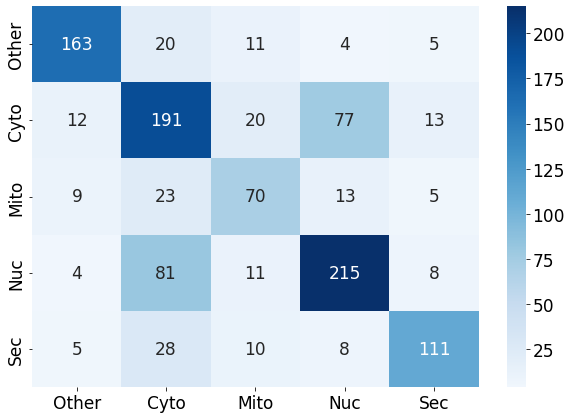

In [206]:
# plot confusion mtx

mtx1 = [[163,  20,  11,   4,   5],
 [ 12, 191,  20,  77,  13],
 [  9,  23,  70,  13,   5],
 [  4,  81,  11, 215,   8],
 [  5,  28,  10,   8, 111]]

df_cm = pd.DataFrame(mtx1, index = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]],
                  columns = [i for i in ["Other", "Cyto", "Mito", "Nuc", "Sec"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, center=((215-4)/2), fmt="d", cmap="Blues")

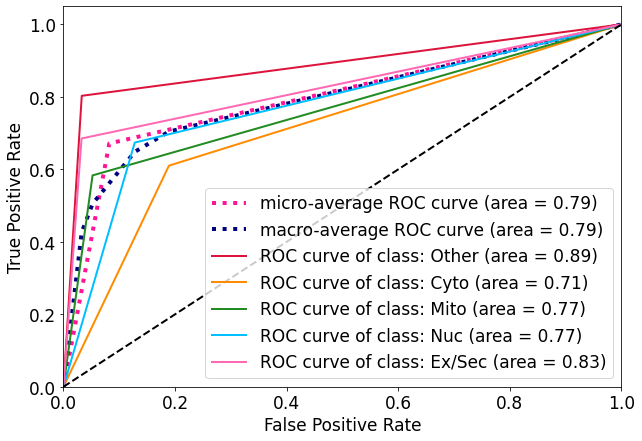

In [207]:
y_test_bin = label_binarize(y_testing, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]
classes = ["Other", "Cyto", "Mito", "Nuc", "Ex/Sec"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pred_bin = label_binarize(pred_test_data, classes=[0, 1, 2, 3, 4])

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], pred_bin[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize = (10,7))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["crimson", "darkorange", "forestgreen", "deepskyblue", "hotpink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class: {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic Curve for Multiclass")
plt.legend(loc="lower right")
plt.show()